# CVDP-LE: NCL to Python

There were several items that I was tasked to work on to begin the transition from NCL to Python:
- For all four variables passed to it (prect, psl, trefht and ts) as is shown at the top of the 2nd cell:
   - [X] Remove the annual cycle (already coded into the 2nd cell).
   - [X] [Form seasonal means for DJF, JFM, MAM, JJA, JAS, SON and annual.](#seasons) (already present in seasonal_trends_timeseries)
   - [X] [Seasonal anomolies, same as above](#season_anoms)
   - [X] [For the SST variable only, mask out the land](#land_mask) (as TS is frequently used as a proxy for SST) prior to any calculations.
   - [ ] [Compute linear trends of those seasonal means.](#not_done) My attempts at this ended where I was calling scipy's signal function, which         doesn't handle missing data. (All functions used in the CVDP-LE need to be able to handle missing data.)
   - Compute global area-weighted averages using cosine of the latitude weighting for all 7 seasons. 
      - [ ] One check that is needed for precipitation only due to many observational precipitation datasets only having values over land: If there are missing values present, check that at least 20% of ocean points have values over them. In NCL I read in a built-in land-sea mask file, computed the % of  points that were ocean, multiplied that times 20% (call this value A), masked land out of the given data array, and then computed the remaining % of non-missing gridpoints (call this value B). If value B was less than value A, I wiped out the data at that timestep for this calculation. What I did in NCL doesn't need to be exactly replicated in python,  we just need to check one way or the other that 20% or more of the ocean has valid data at each timestep (if the first entered timestep of the data has any missing data). 
   - For the PSL variable only
      - [X] [compute the NDJFM seasonal values, and from those seasonal values compute the North Pacific Index (NPI)](#npi), which is the weighted area average of 30:65N, 160:220E. Regress the NPI onto the NDJFM seasonal array (dimensioned time x lat x lon). Here is what atm.trends_timeseries.ipynb needs to do (mostly by calling the seasonal_trends_timeseries function, but I'm completely fine if you'd like a different structure):
      - [X] [compute the NAM time series and global plot using EOF functions](#nam)

Things I'd like to finish up short term:
   <a id="not_done"> </a>
   - [ ] [Linear trends time series?](#lin_ts)
   - Graphics
      - [X] Be able to bring in NCL colormaps
      - [ ] try for NCL projection (not Robinson)
   - [ ] Start putting together functions
      - Need to know which quantities are being saved to which `netcdf` file


How should this be logically setup?

Make use of the functions.py script to house all helper functions


In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import functions as func
import calendar as calendar
from glob import glob
from pathlib import Path
import json

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as mticker
from matplotlib import ticker
import matplotlib.path as mpath
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

from scipy import signal
import scipy
from scipy.stats import linregress

import xskillscore as xs

import xesmf as xe

import geocat.viz as gv
from geocat.comp import eofunc_eofs, eofunc_pcs, month_to_season

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
save_path = "."

### Bring in NCL colorbar (ncl_default)

In [3]:
import sys
import os

# Add the directory to sys.path
#avg_functions.py
script_dir = '/glade/work/richling/CVDP-LE/dev/utils/'
sys.path.append(script_dir)

# Now you can import the script
import analysis as an
import avg_functions as af
import file_creation as fc
import plotting_functions as pf

# Or import specific functions or classes from the script
#from analysis import interp_mask, mask_ocean, land_mask

In [4]:
pf.amwg_cmap, pf.bg_cmap

(<matplotlib.colors.LinearSegmentedColormap at 0x148f0c45cbb0>,
 <matplotlib.colors.LinearSegmentedColormap at 0x148f0f606580>)

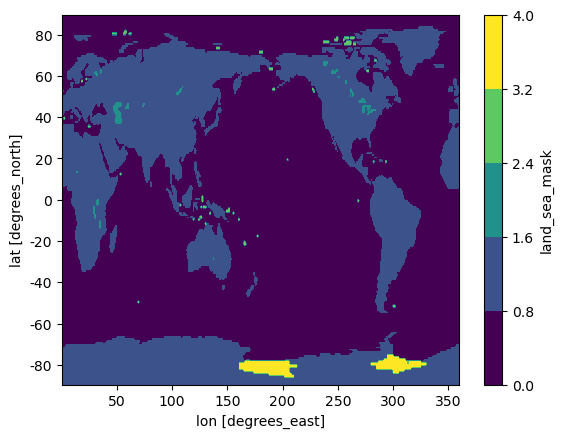

In [5]:
lsmask, ncl_masks = an.land_mask()
#ncl_masks['LSMASK'].plot.contourf(cmap=pf.bg_cmap)
ncl_masks['LSMASK'].plot.contourf()#

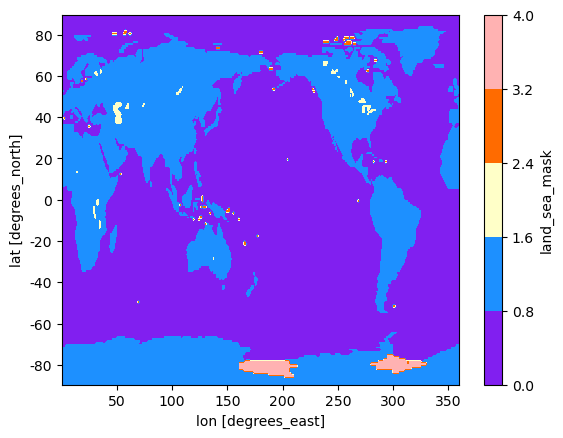

In [6]:
ncl_masks['LSMASK'].plot.contourf(cmap=pf.amwg_cmap)

### Function to read in all the appropriate files

In [7]:
season_list = ["DJF","JFM","MAM","JJA","JAS","SON","ANN"]
var_seasons = {"psl": season_list+["NDJFM"],
               "ts": season_list,
               "trefht": season_list,
               "prect": season_list
               }
ptypes = ["trends","spatialmean"]

In [8]:
#vlist = ['psl','trefht','ts']
#vlist = ['prect','psl','trefht','ts']
vlist = ['psl','ts']
data_dict = {}
for vn in vlist:
    data_dict[vn] = {}
    names = []
    paths = []
    syear = []
    eyear = []
    names_EM = []
    EM_num = []

    print(f"\n-------------------------\nCVDP variable: {vn}\n-------------------------\n")
    with open('../../namelist_byvar/namelist_'+vn) as f:
        for line in f:
            check = line.split(' | ')
            names.append(check[0])
            paths.append(check[1])
            syear.append(check[2])
            eyear.append(check[3])
            ems = check[4].split('-')
            EM_num.append(ems[0])
            names_EM.append(ems[1])

    spatialmeans = {}
    trends = {}
    run_names = []
    for i,mr in enumerate(paths):

        fno = names[i]+'.cvdp_data.'+vn+'.seas_avg_timeseries.'+syear[i]+'-'+eyear[i]+'.nc'
        fno = fno.replace(' ','_')
        fno = Path(f"{fno}")

        #fno_full = names[i]+'.cvdp_data.'+vn+'.timeseries.'+syear[i]+'-'+eyear[i]+'.nc'
        #fno_full = fno_full.replace(' ','_')

        #fno_climo = names[i]+'.cvdp_data.'+vn+'.climo.'+syear[i]+'-'+eyear[i]+'.nc'
        #fno_climo = fno_climo.replace(' ','_')

        fno_anom = names[i]+'.cvdp_data.'+vn+'.trends_timeseries.'+syear[i]+'-'+eyear[i]+'.nc'
        fno_anom = fno_anom.replace(' ','_')
        fno_anom = Path(f"{fno_anom}")

        # set python path object for file
        fno_loc = save_path / fno
        #fno_full_loc = Path(f"{fno_full}")
        #fno_climo_loc = Path(f"{fno_climo}")
        fno_anom_loc = save_path / fno_anom

        is_fno = fno_loc.is_file()
        is_fno_anom = fno_anom_loc.is_file()

        # *** Update this code!! ***
        # Grab run names. This is not ideal or robust, just using for testing
        if "CESM-CAM5-BGC-LE" in mr:
            run_name = "CESM-CAM5-BGC-LE"
            #run_tag = "cesm"
            print("\nCESM-CAM5-BGC-LE\n----------------")
        if "CVDP-OBS" in mr:
            print("\nCVDP-OBS\n--------")
            run_name = "CVDP-OBS"
            #run_tag = "obs"
        # *** ------------------ ***

        data_dict[vn][run_name] = {}

        data_dict[vn][run_name]["season_avg"] = str(fno_loc)
        data_dict[vn][run_name]["trends"] = str(fno_anom_loc)
        run_names.append(run_name)


-------------------------
CVDP variable: psl
-------------------------


CVDP-OBS
--------

CESM-CAM5-BGC-LE
----------------

-------------------------
CVDP variable: ts
-------------------------


CVDP-OBS
--------

CESM-CAM5-BGC-LE
----------------


In [9]:
data_dict

{'psl': {'CVDP-OBS': {'season_avg': 'ERA20C_ERA5.cvdp_data.psl.seas_avg_timeseries.1920-2019.nc',
   'trends': 'ERA20C_ERA5.cvdp_data.psl.trends_timeseries.1920-2019.nc'},
  'CESM-CAM5-BGC-LE': {'season_avg': 'LENS1_#1.cvdp_data.psl.seas_avg_timeseries.1979-2013.nc',
   'trends': 'LENS1_#1.cvdp_data.psl.trends_timeseries.1979-2013.nc'}},
 'ts': {'CVDP-OBS': {'season_avg': 'ERSST_v5.cvdp_data.ts.seas_avg_timeseries.1920-2019.nc',
   'trends': 'ERSST_v5.cvdp_data.ts.trends_timeseries.1920-2019.nc'},
  'CESM-CAM5-BGC-LE': {'season_avg': 'LENS1_#1.cvdp_data.ts.seas_avg_timeseries.1979-2013.nc',
   'trends': 'LENS1_#1.cvdp_data.ts.trends_timeseries.1979-2013.nc'}}}

In [10]:
print(data_dict["psl"][run_names[i]]["season_avg"])
xr.open_dataset(data_dict["psl"][run_names[i]]["season_avg"])

LENS1_#1.cvdp_data.psl.seas_avg_timeseries.1979-2013.nc


<xarray.Dataset>
Dimensions:                (lat: 192, lon: 288, time: 35)
Coordinates:
  * lat                    (lat) float64 -90.0 -89.06 -88.12 ... 89.06 90.0
  * lon                    (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time                   (time) int64 1979 1980 1981 1982 ... 2011 2012 2013
Data variables: (12/16)
    psl_spatialmean_ann    (time, lat, lon) float64 ...
    psl_spatialmean_ndjfm  (time, lat, lon) float32 ...
    psl_spatialmean_djf    (time, lat, lon) float32 ...
    psl_spatialmean_jfm    (time, lat, lon) float32 ...
    psl_spatialmean_mam    (time, lat, lon) float32 ...
    psl_spatialmean_jja    (time, lat, lon) float32 ...
    ...                     ...
    psl_trends_djf         (time, lat, lon) float32 ...
    psl_trends_jfm         (time, lat, lon) float32 ...
    psl_trends_mam         (time, lat, lon) float32 ...
    psl_trends_jja         (time, lat, lon) float32 ...
    psl_trends_jas         (time, lat, lon) float32 ...
    psl_trends_son         (time, lat, lon) float32 ...
Attributes:
    units:    hPa
    run:      CESM-CAM5-BGC-LE
    yrs:      [1979 2013]

In [11]:
xr.open_dataset(data_dict["psl"][run_names[i]]["season_avg"])

<xarray.Dataset>
Dimensions:                (lat: 192, lon: 288, time: 35)
Coordinates:
  * lat                    (lat) float64 -90.0 -89.06 -88.12 ... 89.06 90.0
  * lon                    (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time                   (time) int64 1979 1980 1981 1982 ... 2011 2012 2013
Data variables: (12/16)
    psl_spatialmean_ann    (time, lat, lon) float64 ...
    psl_spatialmean_ndjfm  (time, lat, lon) float32 ...
    psl_spatialmean_djf    (time, lat, lon) float32 ...
    psl_spatialmean_jfm    (time, lat, lon) float32 ...
    psl_spatialmean_mam    (time, lat, lon) float32 ...
    psl_spatialmean_jja    (time, lat, lon) float32 ...
    ...                     ...
    psl_trends_djf         (time, lat, lon) float32 ...
    psl_trends_jfm         (time, lat, lon) float32 ...
    psl_trends_mam         (time, lat, lon) float32 ...
    psl_trends_jja         (time, lat, lon) float32 ...
    psl_trends_jas         (time, lat, lon) float32 ...
    psl_trends_son         (time, lat, lon) float32 ...
Attributes:
    units:    hPa
    run:      CESM-CAM5-BGC-LE
    yrs:      [1979 2013]

In [12]:
xr.open_dataset("ERA20C_ERA5.cvdp_data.psl.trends_timeseries.1920-2019.nc")

<xarray.Dataset>
Dimensions:  (time: 1200, lat: 181, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1920-01-01 1920-02-01 ... 2019-12-01
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
    month    (time) int64 ...
Data variables:
    psl      (time, lat, lon) float32 ...

In [13]:
data_dict["psl"][run_names[i]]["trends"]

'LENS1_#1.cvdp_data.psl.trends_timeseries.1979-2013.nc'

In [14]:
%%time



# This will be the "main" function?

clobber = False
#def run_things():
if 1==1:
    #vlist = ['psl','trefht','ts']
    #vlist = ['prect','psl','trefht','ts']
    vlist = ['psl','ts']
    #vlist = ['psl']
    #vlist = ['psl','prect','ts']

    for vn in vlist:

        names = []
        paths = []
        syear = []
        eyear = []
        names_EM = []
        EM_num = []

        print(f"\n-------------------------\nCVDP variable: {vn}\n-------------------------\n")
        with open('../../namelist_byvar/namelist_'+vn) as f:
            for line in f:
                check = line.split(' | ')
                names.append(check[0])
                paths.append(check[1])
                syear.append(check[2])
                eyear.append(check[3])
                ems = check[4].split('-')
                EM_num.append(ems[0])
                names_EM.append(ems[1])

        for i,mr in enumerate(paths):
            run_name = run_names[i]
            fno_loc = data_dict[vn][run_name]["season_avg"]
            fno_anom_loc = data_dict[vn][run_name]["trends"]

            fils = sorted(glob(mr))
            print(f"  Input file(s) glob pattern: {mr}\n")
            print(f"  Input file(s): {fils}\n")


            # get the full dataset for variable(s)
            farr,err = fc.data_read_in_3D(fils,syear[i],eyear[i],vn)
            print("AAAAOOOOGGGAAAAA:",farr.attrs,"\n")

            if not err:

                # If TS anomolies, clip the low end values
                '''
                QUESTION: Is this appropriate? I don't know if this is only
                 for trends. Check with Adam!
                '''
                '''
                if vn == "ts":
                    farr_ts_r = farr
                    farr_ts = np.where(farr<-1.8, -1.8, farr)
                    farr = xr.DataArray(data=farr_ts.data,
                                        dims=farr_ts_r.dims,
                                        attrs=farr_ts_r.attrs,
                                        name=farr_ts_r.name,
                                        coords=farr_ts_r.coords)
                '''

                # remove annual trend
                #--------------------
                farr_clim = farr.groupby('time.month').mean(dim='time')   # calculate climatology
                #farr_clim.attrs.update(farr.attrs)

                farr_anom = farr.groupby('time.month') - farr_clim   # form anomalies
                print("farr_anom:",farr_anom.attrs,"\n")
                farr_anom.attrs.update(farr.attrs)
                farr_anom.attrs['run'] = run_name

                # Add desired start and end years to metadata
                season_yrs = np.unique(farr["time.year"])
                farr_anom.attrs['yrs'] = [season_yrs[0],season_yrs[-1]]

                # Rename variable to CVDP variable name
                farr_anom = farr_anom.rename(vn)
                Path(fno_anom_loc).unlink(missing_ok=True)
                farr_anom.to_netcdf(fno_anom_loc)

                # get seasonal averages for spatial means and trends (anomolies?)
                #finarr.attrs.update(farr.attrs)
                #finarr.attrs['run'] = run_name
                #finarr.attrs['yrs'] = [season_yrs[0],season_yrs[-1]]

                finarr = af.seasonal_timeseries(farr, farr_anom, vn, run_name)
                print("finarr:",finarr.attrs,"\n")
                Path(fno_loc).unlink(missing_ok=True)
                finarr.to_netcdf(fno_loc)



    print("ALL DONE!")

    #with open('data_dict.json', 'w') as json_file:
    #    json.dump(data_dict, json_file, indent=4)


-------------------------
CVDP variable: psl
-------------------------

  Input file(s) glob pattern: /glade/campaign/cgd/cas/asphilli/CVDP-OBS/era20c_era5.mon.mean.msl.190001-201912.nc

  Input file(s): ['/glade/campaign/cgd/cas/asphilli/CVDP-OBS/era20c_era5.mon.mean.msl.190001-201912.nc']

  Var: PSL?

  Var: psl?

  Var: slp?

  Var: SLP?

  Var: prmsl?

  Var: msl?

    ** The variable msl is used for psl **

  Var: slp_dyn?

  Units: Pa 

AAAAOOOOGGGAAAAA: {'units': 'hPa'} 

farr_anom: {'units': 'hPa'} 

finarr: {'units': 'hPa', 'run': 'CVDP-OBS', 'yrs': [1920, 2019]} 

  Input file(s) glob pattern: /glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/*/b.e11.B*C5CNBDRD.f09_g16.001.cam**.PSL.*.nc

  Input file(s): ['/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PSL/b.e11.B20TRC5CNBDRD.f09_g16.001.cam.h0.PSL.185001-200512.nc', '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PSL/b.e1

In [15]:


# Or import specific functions or classes from the script
#from analysis import interp_mask, mask_ocean, land_mask

plot_dict_mean = {"psl": {"range": np.linspace(968,1048,21),
                          "ticks": np.arange(976,1041,8),
                          #"cbarticks":"",
                          #"diff_cbarticks":np.arange(-10,11,2),
                          "diff_range": np.arange(-11,12,1),
                          "diff_ticks": np.arange(-10,11,1),
                          "cmap": pf.amwg_cmap,
                          "units":"hPa"},
                  "ts": {"range": np.linspace(-2,38,21),
                         "ticks": np.linspace(-2,38,21),
                         #"ticks": np.arange(0,38,2),
                         #"tick_labels": np.arange(0,38,2),
                         "cbarticks": np.arange(0,37,2),
                         "diff_cbarticks":np.arange(-5,6,1),
                         "diff_range": np.arange(-5.5,5.6,0.5),
                         "diff_ticks": np.arange(-5.5,5.6,0.5),
                         #"diff_ticks": np.arange(-5,6,1),
                         "cmap": pf.amwg_cmap,
                         "units":"C"}
            }

plot_dict_trends = {"psl": {"range": np.linspace(-9,9,19),
                            "ticks": np.arange(-8, 9, 1),
                            "cbarticks": np.arange(0,37,2),
                            "diff_cbarticks":np.arange(-8, 9, 1),
                            "cmap": pf.amwg_cmap,
                            "units":"hPa"},
                    "ts": {"range": [-8, -7, -6, -5, -4, -3, -2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8],
                            #"ticks": [-6, -4, -2, -0.5, 0, 0.5, 2, 4, 6],
                            "ticks": [-8, -7, -6, -5, -4, -3, -2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8],
                            #"diff_range": np.arange(-5,6,1),
                            #"diff_ticks": np.arange(-5,6,1),
                            "cbarticks": [-6, -4, -2, -0.5, 0, 0.5, 2, 4, 6],
                            "cmap": pf.amwg_cmap,
                            "units":"C"},
                    "NAM": {"range": np.linspace(-8, 8, 17),
                            "ticks": np.arange(-7,8,1),
                            "cmap": pf.amwg_cmap,
                            "units": "hPa"},
                    "PNA": {"range": np.linspace(-8, 8, 17),
                            "ticks": np.arange(-7,8,1),
                            "cmap": pf.amwg_cmap,
                            "units": "hPa"},
                    "PNO": {"range": np.linspace(-8, 8, 17),
                            "ticks": np.arange(-7,8,1),
                            "cmap": pf.amwg_cmap,
                            "units": "hPa"},
                    "SAM": {"range": np.linspace(-8, 8, 17),
                            "ticks": np.arange(-7,8,1),
                            "cmap": pf.amwg_cmap,
                            "units": "hPa"},
                    "PSA1": {"range": np.linspace(-8, 8, 17),
                            "ticks": np.arange(-7,8,1),
                            "cmap": pf.amwg_cmap,
                            "units": "hPa"},
                    "PSA2": {"range": np.linspace(-8, 8, 17),
                            "ticks": np.arange(-7,8,1),
                            "cmap": pf.amwg_cmap,
                            "units": "hPa"}
            }

plot_dict = {"spatialmean": plot_dict_mean,
              "trends": plot_dict_trends}




---

<a id="land_mask"> </a>
## SST and TS

Mask out the land for TS to mimic SSTs

#### Land-Sea Mask

Use `landsea.nc' 1km x 1km file to use as mask

* This data will be regridded to any incoming TS file regardless of spatital resolution

# Stacked global lat/lon

In [16]:
nh_vars = ["NAM"]
sh_vars = ["SAM", "PSA1", "PSA2"]
eof_vars = nh_vars+sh_vars

In [17]:
def indmem_plot(finarrs, arrs, vn, var=None, season="ANN", ptype="trends", plot_dict=None, map_type="global", debug=False):
    nh_vars = ["NAM"]
    sh_vars = ["SAM", "PSA1", "PSA2"]
    eof_vars = nh_vars+sh_vars
    if vn == "ts":
        plot_name = f"output/sst_{ptype}_{season.lower()}.indmem.png"
        title = f'SST {ptype.capitalize()} ({season.upper()})\n'
    elif season == "NDJFM":
        plot_name = f"output/npi_pattern_{season.lower()}.indmem.png"
        title = f'NPI Pattern ({season.upper()})\n'
    #elif var == "NAM" or var == "SAM":
    elif var in eof_vars:
        plot_name = f"output/{var.lower()}_pattern_{season.lower()}.indmem.png"
        title = f'{var} Pattern ({season.upper()})\n'
    else:
        plot_name = f"output/{vn}_{ptype}_{season.lower()}.indmem.png"
        title = f'{vn.upper()} {ptype.capitalize()} ({season.upper()})\n'

    if map_type == "global":
        pf.stacked_global_latlon_plot(vn, finarrs, arrs, plot_dict, title, plot_name, ptype, season, debug)
    if map_type == "polar":
        pf.stacked_polar_plot(vn, var, finarrs, arrs, plot_dict, title, plot_name, ptype, season, debug)


def indmemdiff_plot(finarrs, arr_diff, vn, var, season, ptype, plot_dict, map_type, debug=False):
    """
    d
    """
    nh_vars = ["NAM"]
    sh_vars = ["SAM", "PSA1", "PSA2"]
    eof_vars = nh_vars+sh_vars
    #unit = finarrs[0].units
    try:
        run = f"{finarrs[0].run} - {finarrs[1].run}"
    except:
        print()
    try:
        run = f"{finarrs[0][vn].run} - {finarrs[1][vn].run}"
    except:
        print()
    print("vn:",vn,"\n")
    # Set file name and figure title
    if vn == "ts":
        plot_name = f"output/sst_{ptype}_{season.lower()}.indmemdiff.png"
        title = f'SST {ptype.capitalize()} Differences ({season.upper()})\n'
    elif season == "NDJFM":
        plot_name = f"output/npi_pattern_{season.lower()}.indmemdiff.png"
        title = f'NPI Pattern Differences ({season.upper()})\n'
    #elif var == "NAM" or var == "SAM":
    elif var in eof_vars:
        plot_name = f"output/{var.lower()}_pattern_{season.lower()}.indmemdiff.png"
        title = f'{var} Pattern Differences ({season.upper()})\n'
    else:
        print("no way its here?")
        plot_name = f"output/{vn}_{ptype}_{season.lower()}.indmemdiff.png"
        title = f'{vn.upper()} {ptype.capitalize()} Differences ({season.upper()})\n'

    if map_type == "global":
        print(title,"\n",plot_name)
        pf.global_latlon_diff_plot(vn, run, arr_diff, ptype, plot_dict, title, plot_name, debug)
    if map_type == "polar":
        print(title,"\n",plot_name)
        pf.polar_diff_plot(vn, var, run, arr_diff, ptype, plot_dict, title, plot_name, debug)






def ensemble_plot(finarrs, arrs, arr_diff, vn, var=None, season="ANN", ptype="trends", plot_dict=None, map_type="global", debug=False):
    #if not var:
    #    var = vn
    nh_vars = ["NAM"]
    sh_vars = ["SAM", "PSA1", "PSA2"]
    eof_vars = nh_vars+sh_vars
    print("var",var,"\n")
    # Set file name and figure title
    if vn == "ts":
        plot_name = f"output/sst_{ptype}_{season.lower()}.summary.png"
        #title = f'SST {ptype.capitalize()} ({season})\n'
        title = f'Ensemble Summary: SST {ptype.capitalize()} ({season.upper()})'
    elif season == "NDJFM":
        plot_name = f"output/npi_pattern_{season.lower()}.summary.png"
        #npi_pattern_ndjfm.summary.png
        #title = f'NPI Pattern ({season})\n'
        title = f'Ensemble Summary: NPI Pattern ({season.upper()})'
    elif var in eof_vars:
        print("IS IT HERE?")
        plot_name = f"output/{var.lower()}_pattern_{season.lower()}.summary.png"
        title = f'Ensemble Summary: {var} Pattern ({season.upper()})\n'
    else:
        print("OR HERE?")
        plot_name = f"output/{vn}_{ptype}_{season.lower()}.summary.png"
        #title = f'{vn.upper()} {ptype.capitalize()} ({season})\n'
        title = f'Ensemble Summary: {vn.upper()} {ptype.capitalize()} ({season.upper()})'

    if map_type == "global":
        pf.global_ensemble_plot(finarrs, arrs, arr_diff, vn, season, ptype, plot_dict, title, plot_name, debug)
    if map_type == "polar":
        pf.polar_ensemble_plot(finarrs, arrs, arr_diff, vn, var, season, ptype, plot_dict, title, plot_name, debug)

In [18]:
finarrs_dict = {}

cvdp_var = "psl"
psl_cesm_avg = xr.open_dataset(data_dict[cvdp_var][run_names[1]]["season_avg"])
psl_obs_avg = xr.open_dataset(data_dict[cvdp_var][run_names[0]]["season_avg"])

psl_cesm_trends = xr.open_dataset(data_dict[cvdp_var][run_names[1]]["trends"])
psl_obs_trends = xr.open_dataset(data_dict[cvdp_var][run_names[0]]["trends"])

finarrs_dict[cvdp_var] = [psl_cesm_avg,psl_obs_avg]


cvdp_var = "ts"
ts_cesm_avg = xr.open_dataset(data_dict[cvdp_var][run_names[1]]["season_avg"])
ts_obs_avg = xr.open_dataset(data_dict[cvdp_var][run_names[0]]["season_avg"])

#ts_cesm_trends = xr.open_dataset(data_dict[cvdp_var][run_names[1]]["trends"])
#ts_obs_trends = xr.open_dataset(data_dict[cvdp_var][run_names[0]]["trends"])

finarrs_dict[cvdp_var] = [ts_cesm_avg,ts_obs_avg]

vn ts 
---------------------

ptype trends 
---------------------

The input array lat/lon shape does not match the land/sea mask array.
Regridding to land/sea lats and lons
The input array lat/lon shape does not match the land/sea mask array.
Regridding to land/sea lats and lons
the lons ARE the same
the lats ARE the same


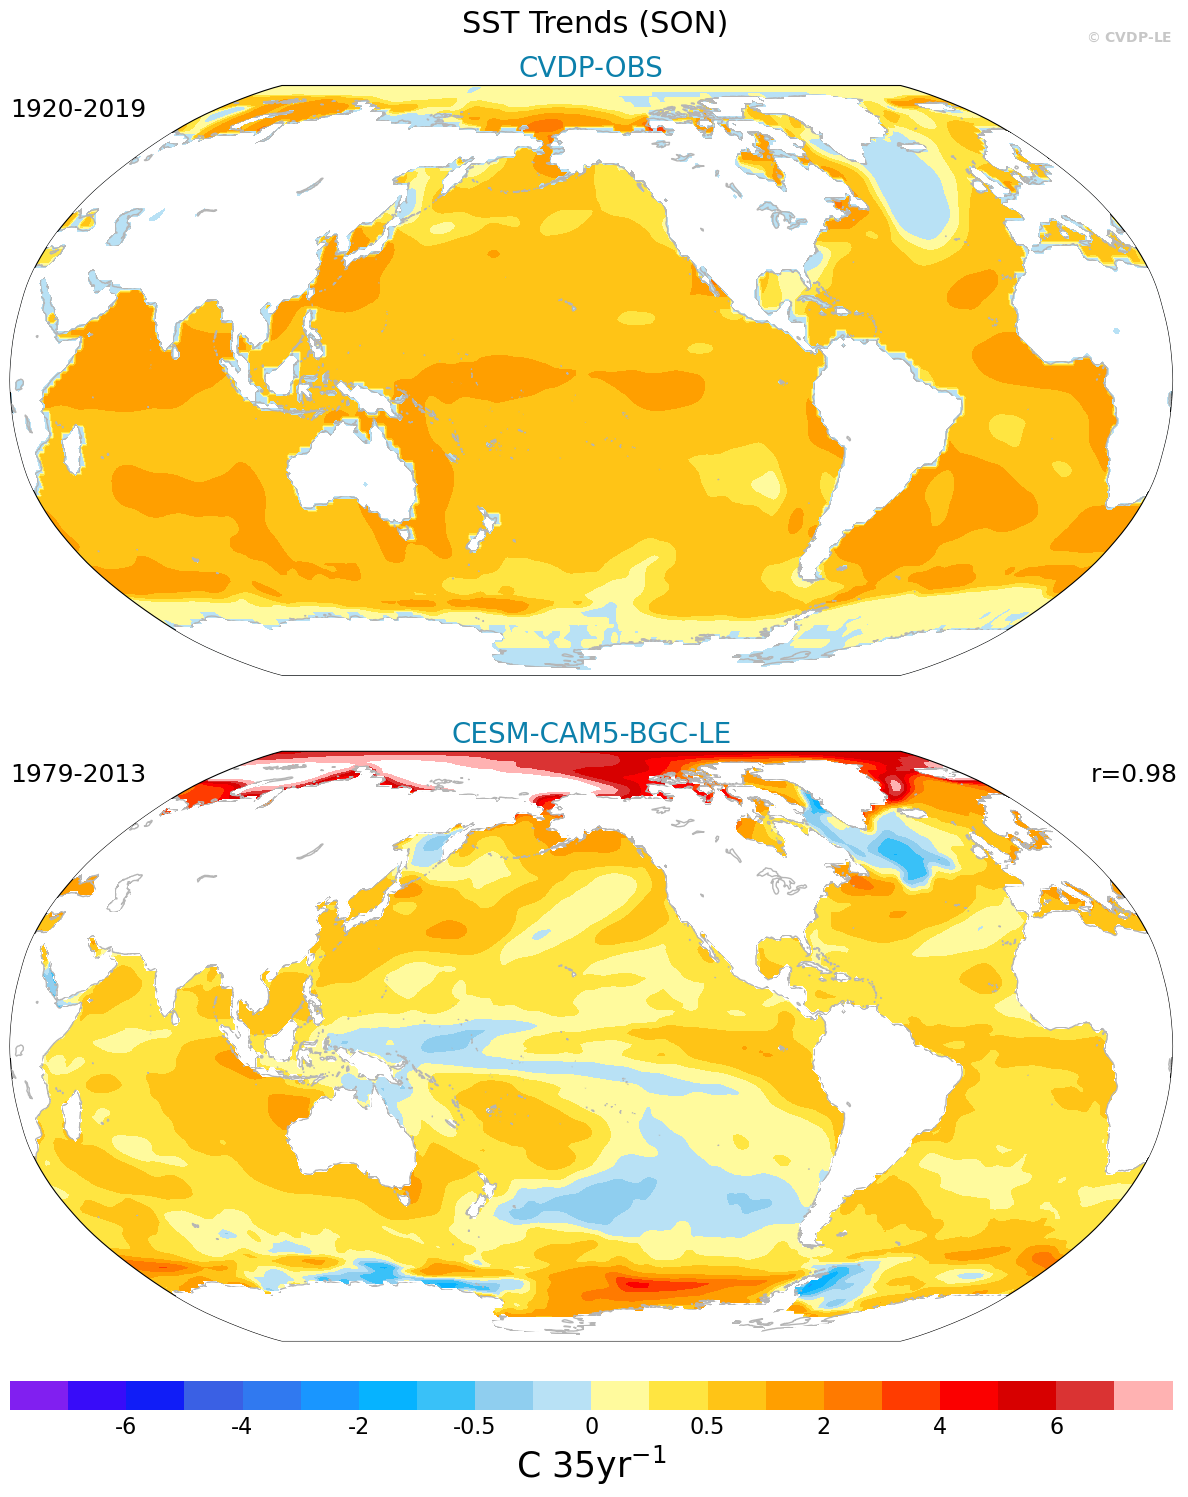


vn: ts 

SST Trends Differences (SON)
 
 output/sst_trends_son.indmemdiff.png
cbarticks diff plot trends [-6, -4, -2, -0.5, 0, 0.5, 2, 4, 6] 

tick_labels diff plot trends ['', '', '-6', '', '-4', '', '-2', '', '-0.5', '', '0', '', '0.5', '', '2', '', '4', '', '6', '', ''] 



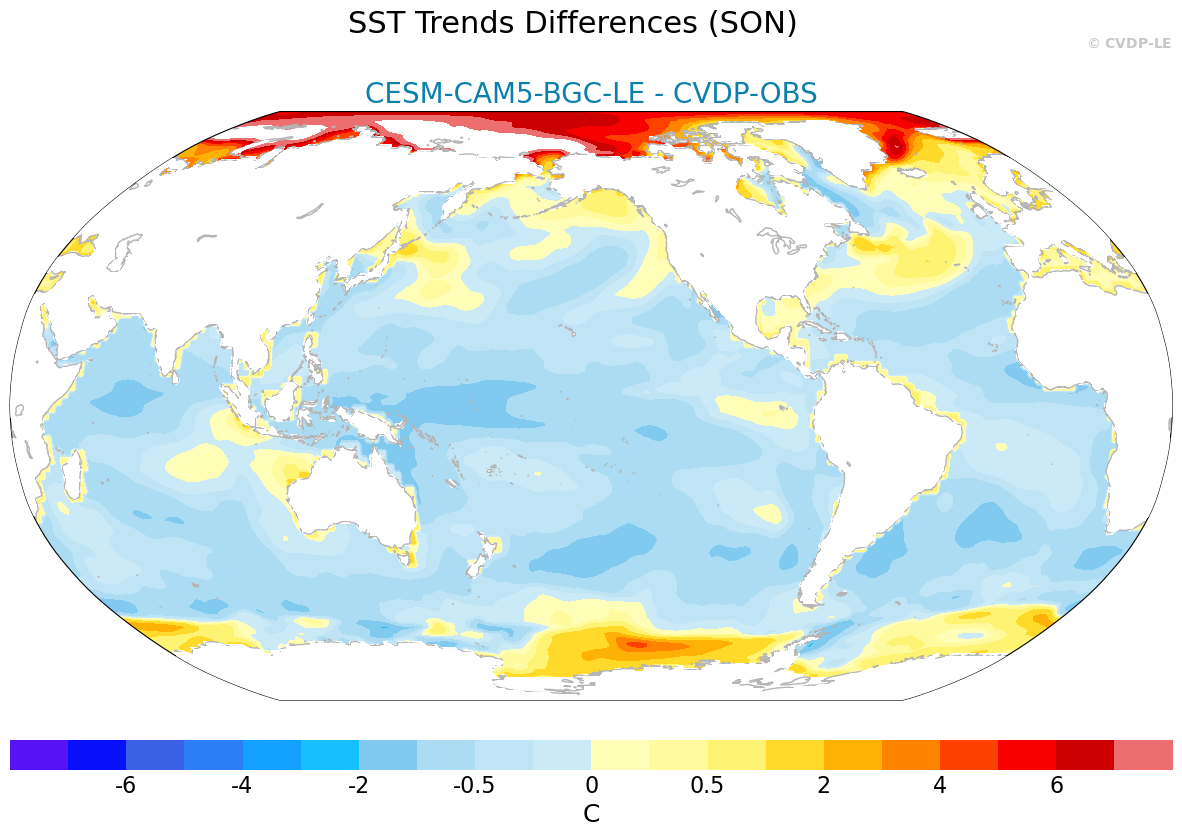

var None 

1979-2013 

1920-2019 



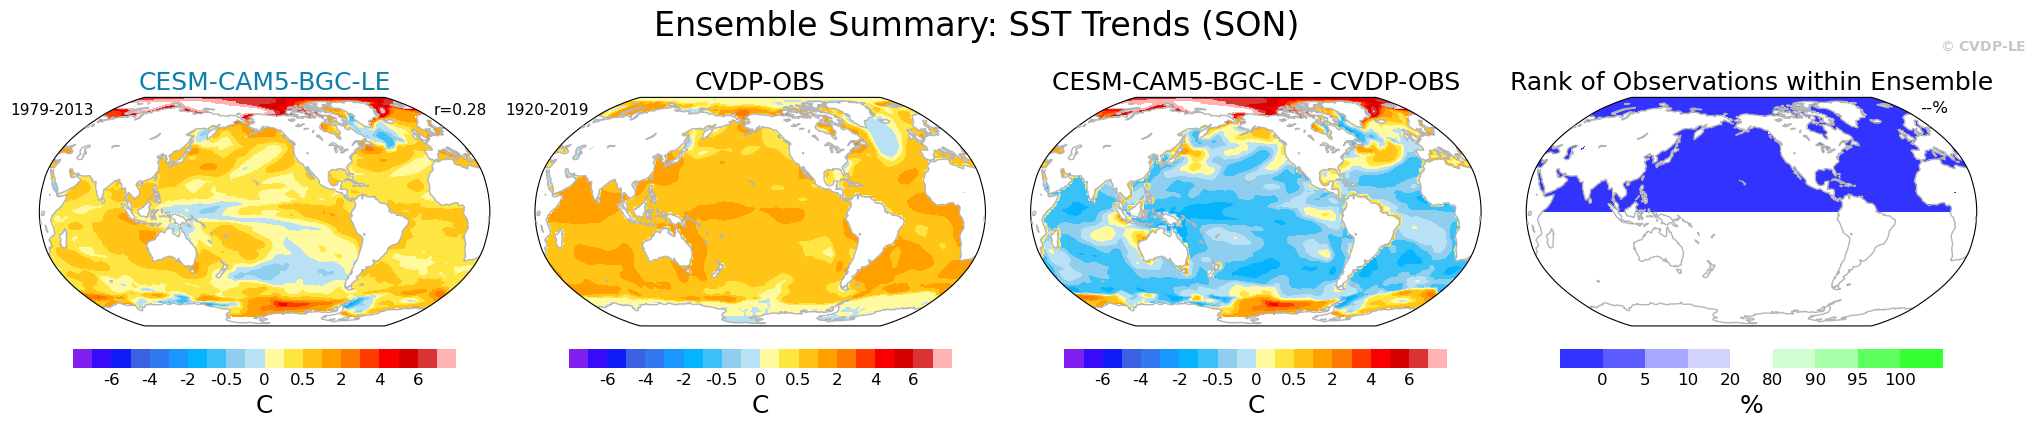

ptype spatialmean 
---------------------

The input array lat/lon shape does not match the land/sea mask array.
Regridding to land/sea lats and lons
The input array lat/lon shape does not match the land/sea mask array.
Regridding to land/sea lats and lons
the lons ARE the same
the lats ARE the same


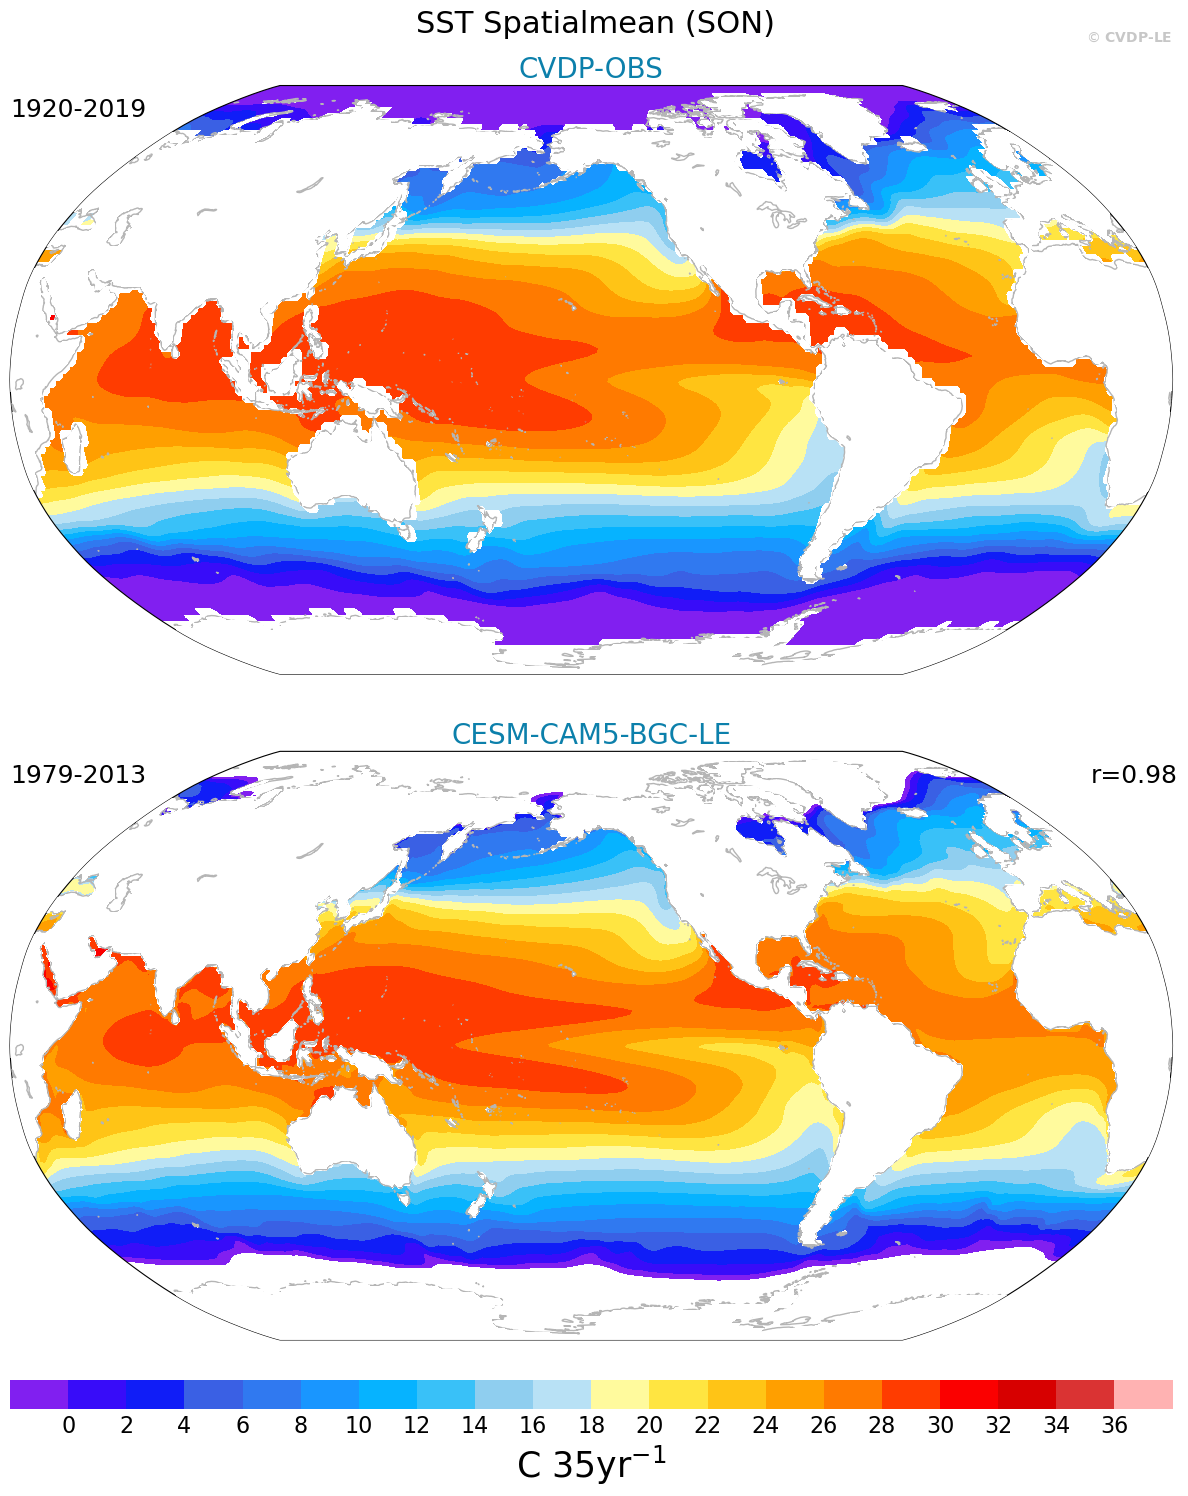


vn: ts 

SST Spatialmean Differences (SON)
 
 output/sst_spatialmean_son.indmemdiff.png
cbarticks diff plot spatialmean [-5 -4 -3 -2 -1  0  1  2  3  4  5] 

tick_labels diff plot spatialmean ['', '-5', '', '-4', '', '-3', '', '-2', '', '-1', '', '0', '', '1', '', '2', '', '3', '', '4', '', '5', ''] 



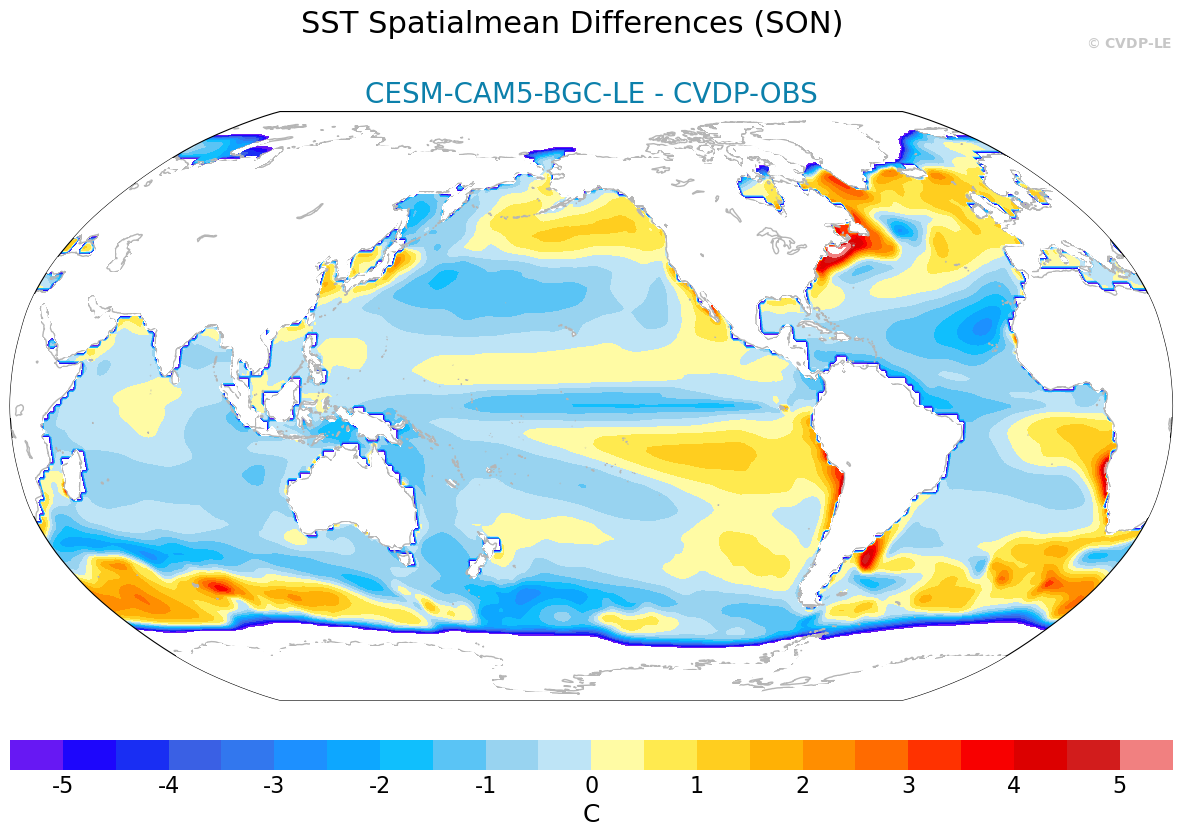

var None 

1979-2013 

1920-2019 



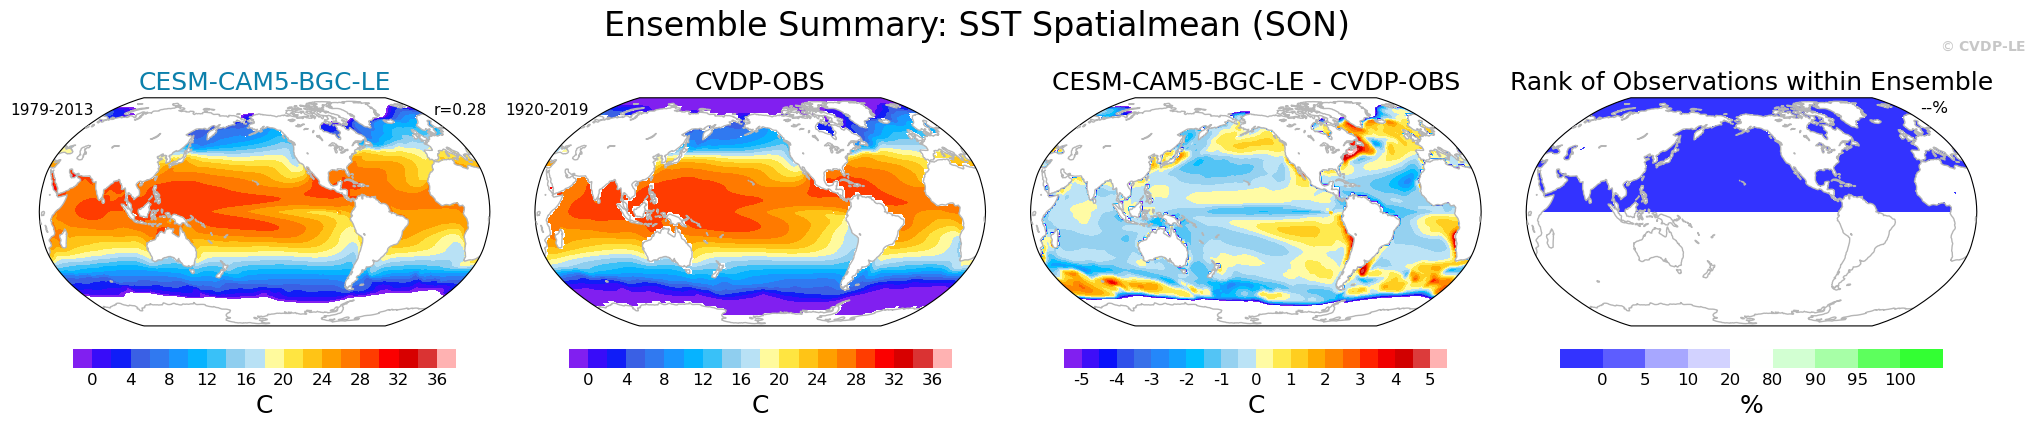

vn psl 
---------------------

ptype trends 
---------------------

The ensemble array lat/lon shape does not match the obs mask array.
Regridding to ensemble lats and lons
psl plotting things...
psl plotting things...


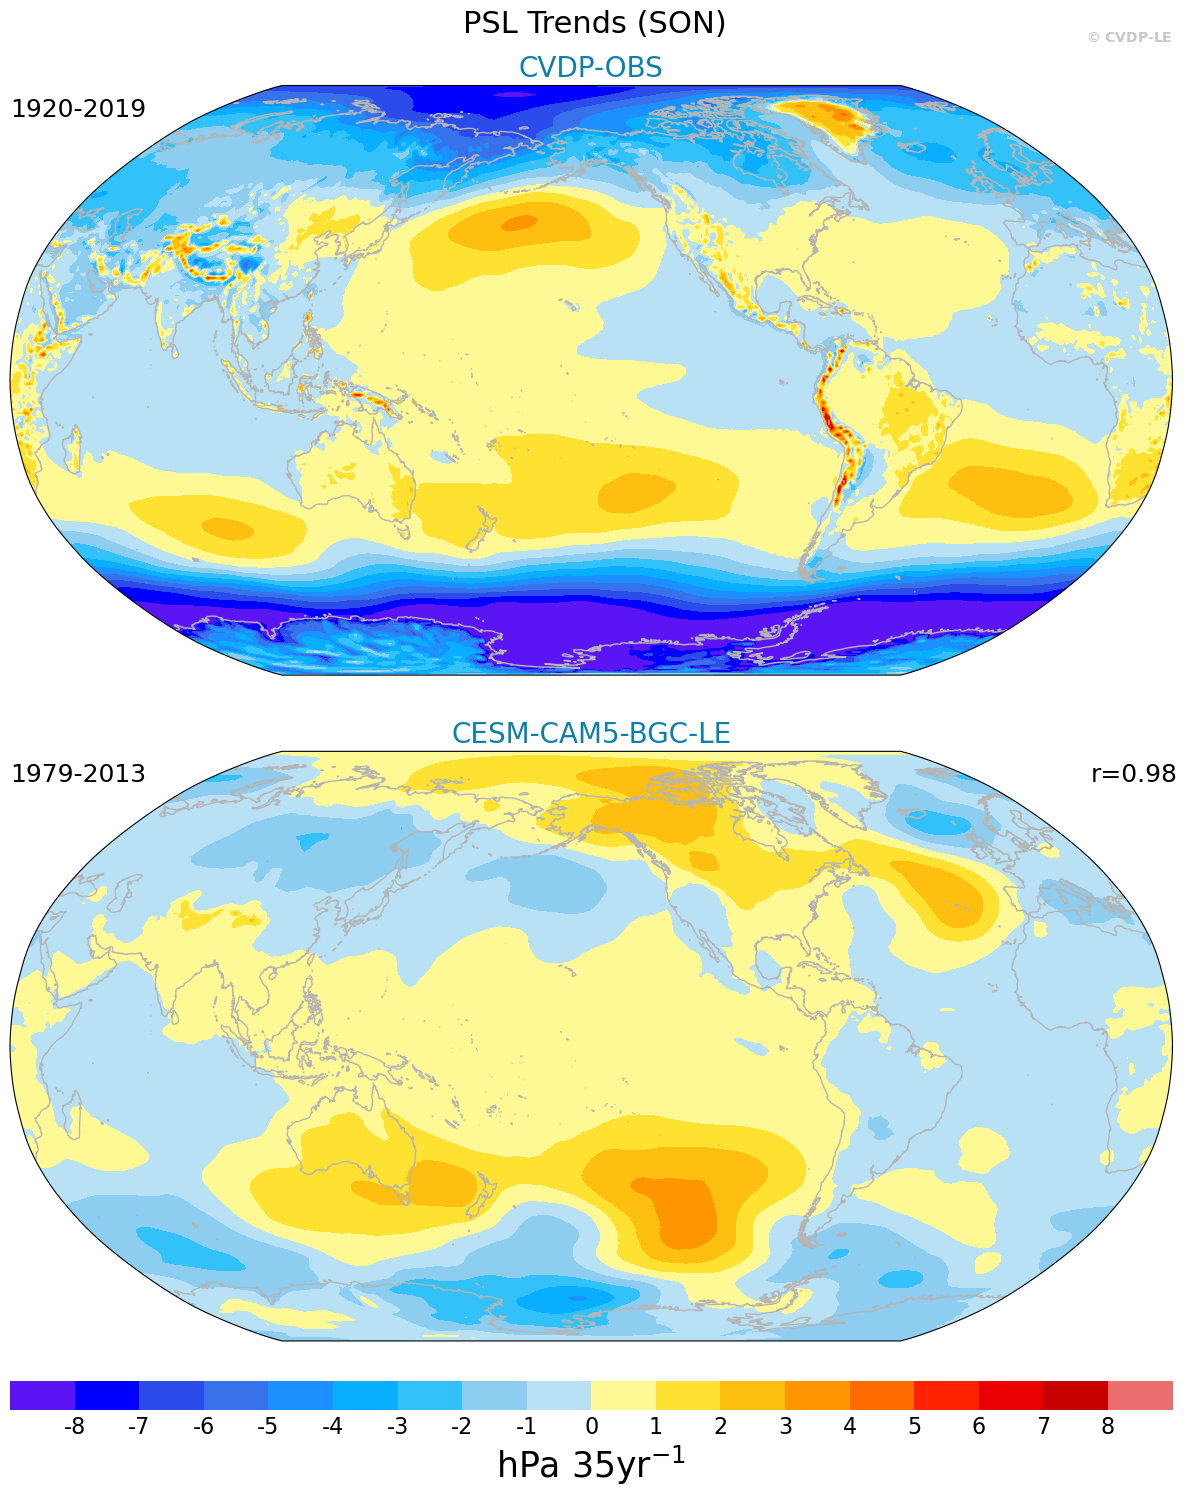


vn: psl 

no way its here?
PSL Trends Differences (SON)
 
 output/psl_trends_son.indmemdiff.png
cbarticks diff plot trends [-8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8] 

tick_labels diff plot trends ['-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6', '7', '8'] 



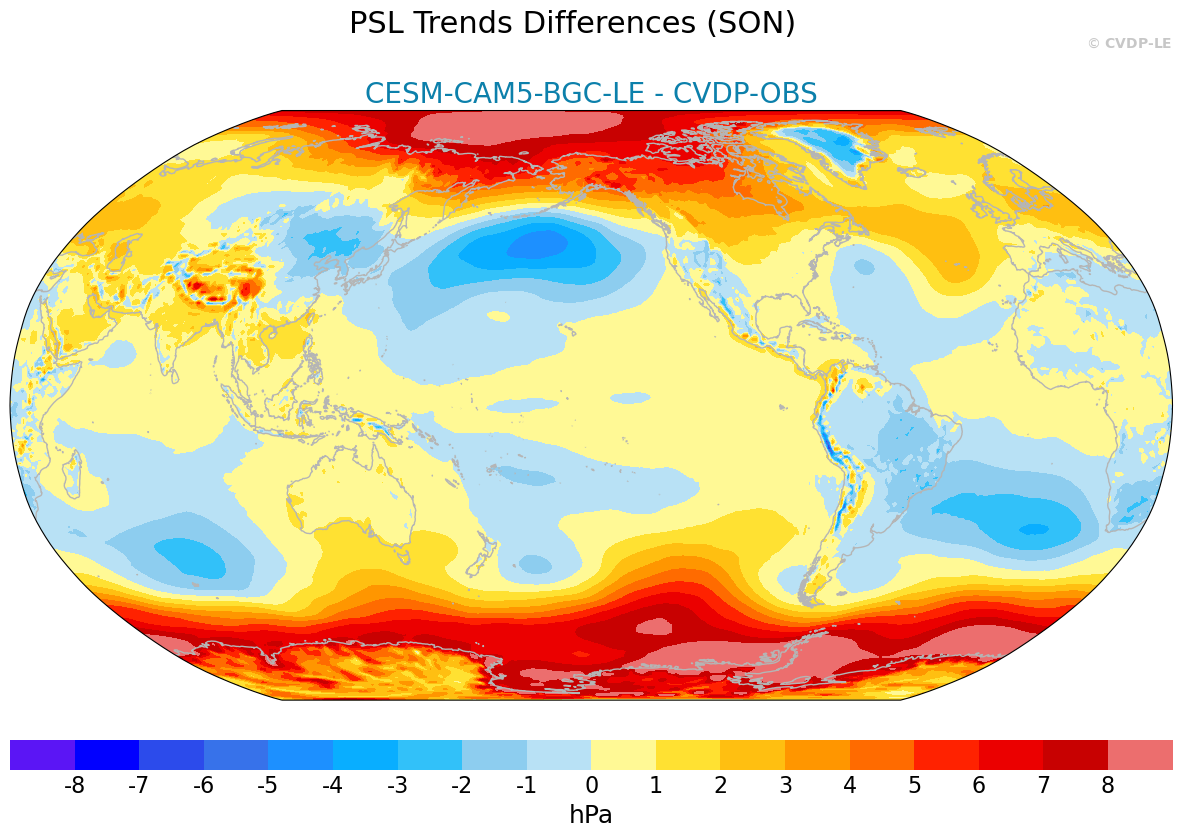

var None 

OR HERE?
1979-2013 

1920-2019 



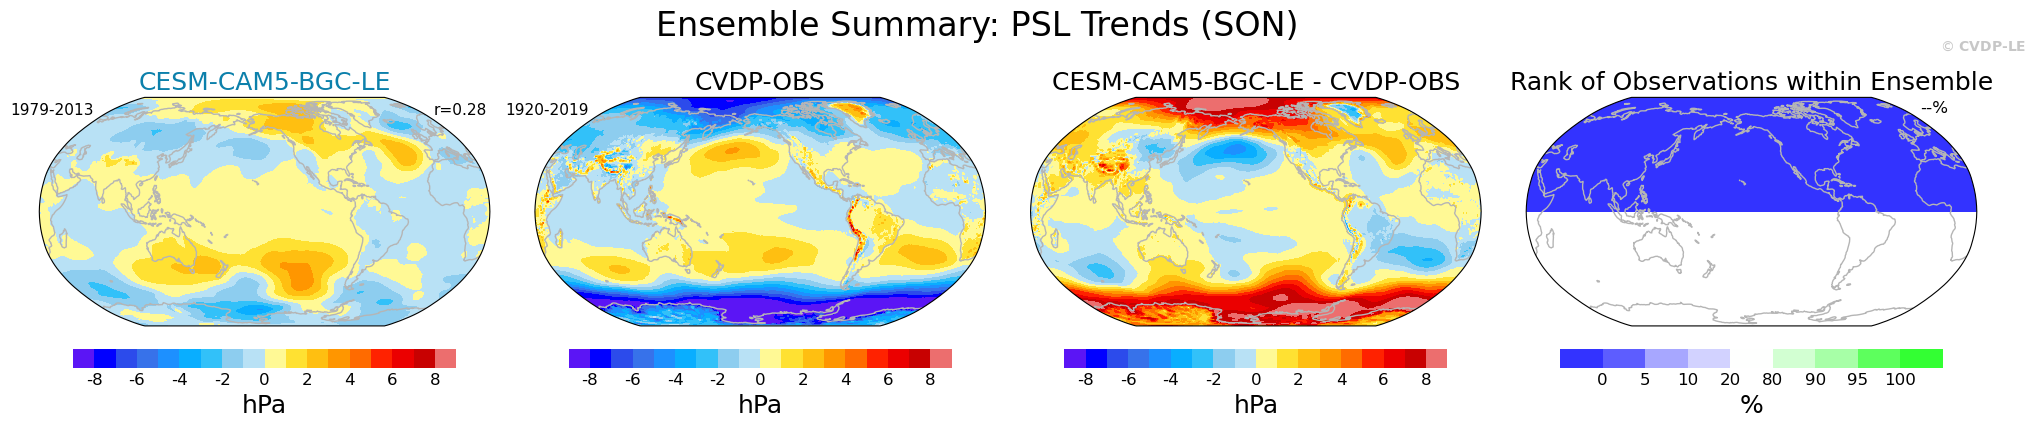

ptype spatialmean 
---------------------

The ensemble array lat/lon shape does not match the obs mask array.
Regridding to ensemble lats and lons
psl plotting things...
psl plotting things...


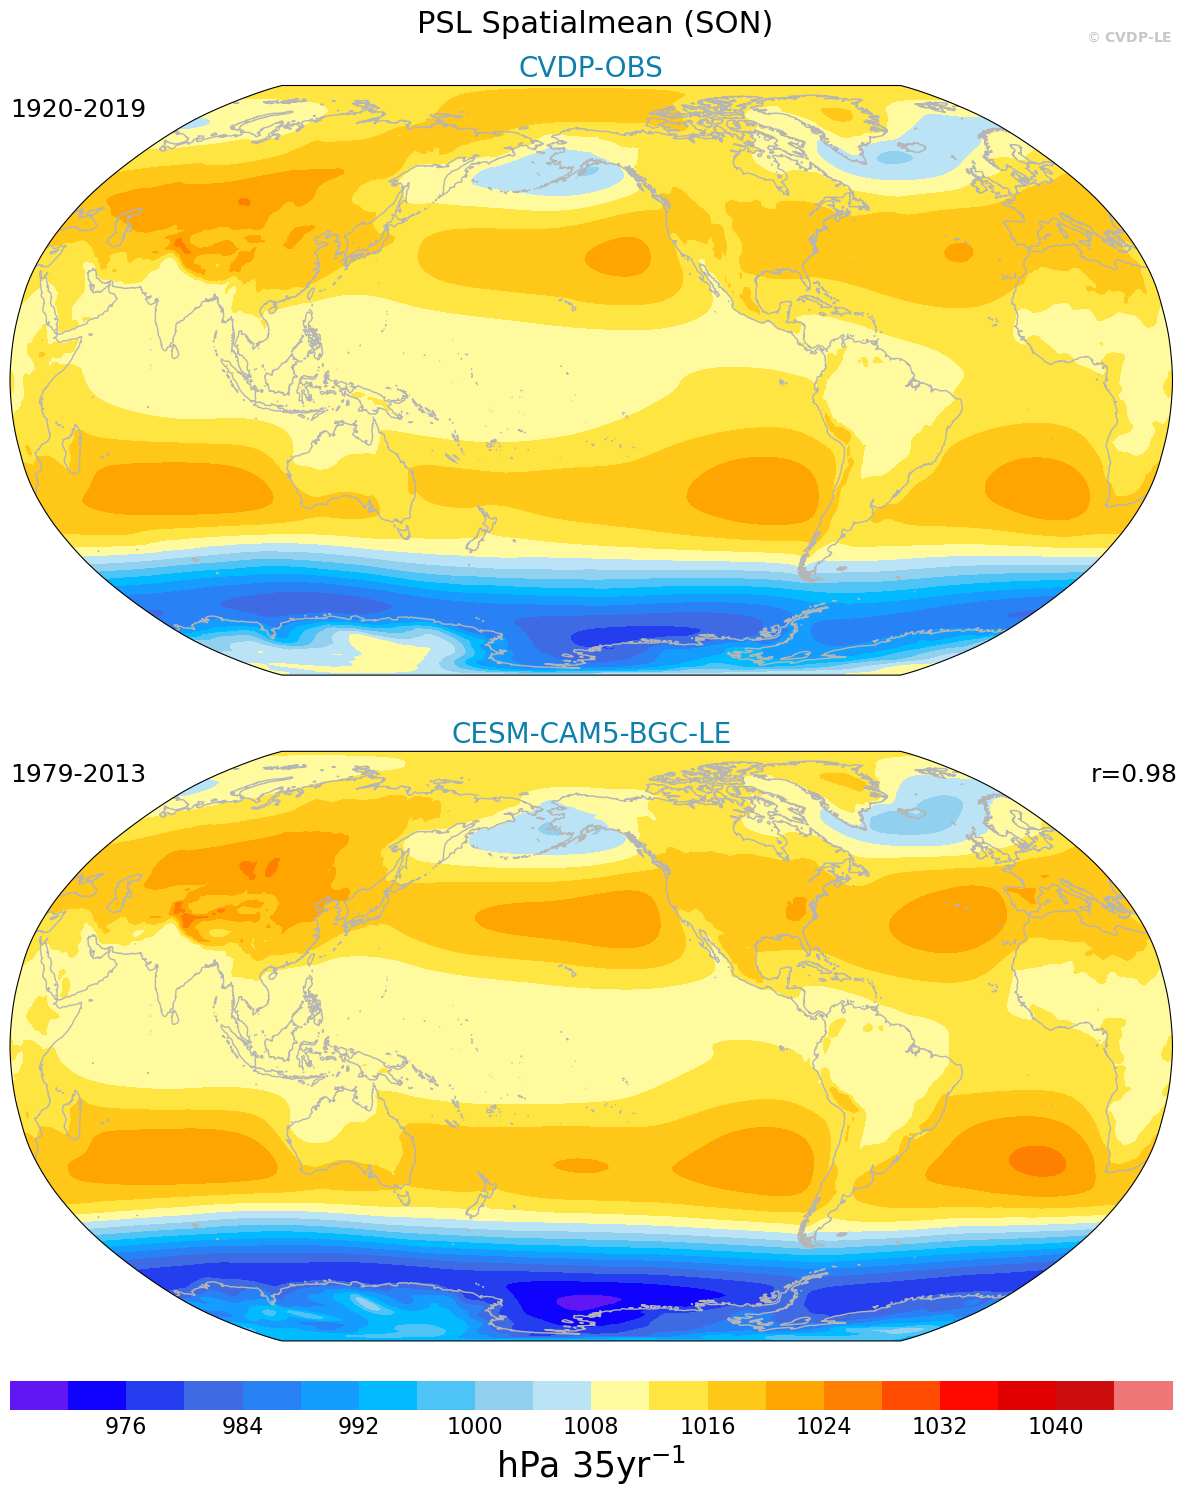


vn: psl 

no way its here?
PSL Spatialmean Differences (SON)
 
 output/psl_spatialmean_son.indmemdiff.png
cbarticks diff plot spatialmean [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10] 

tick_labels diff plot spatialmean ['-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'] 



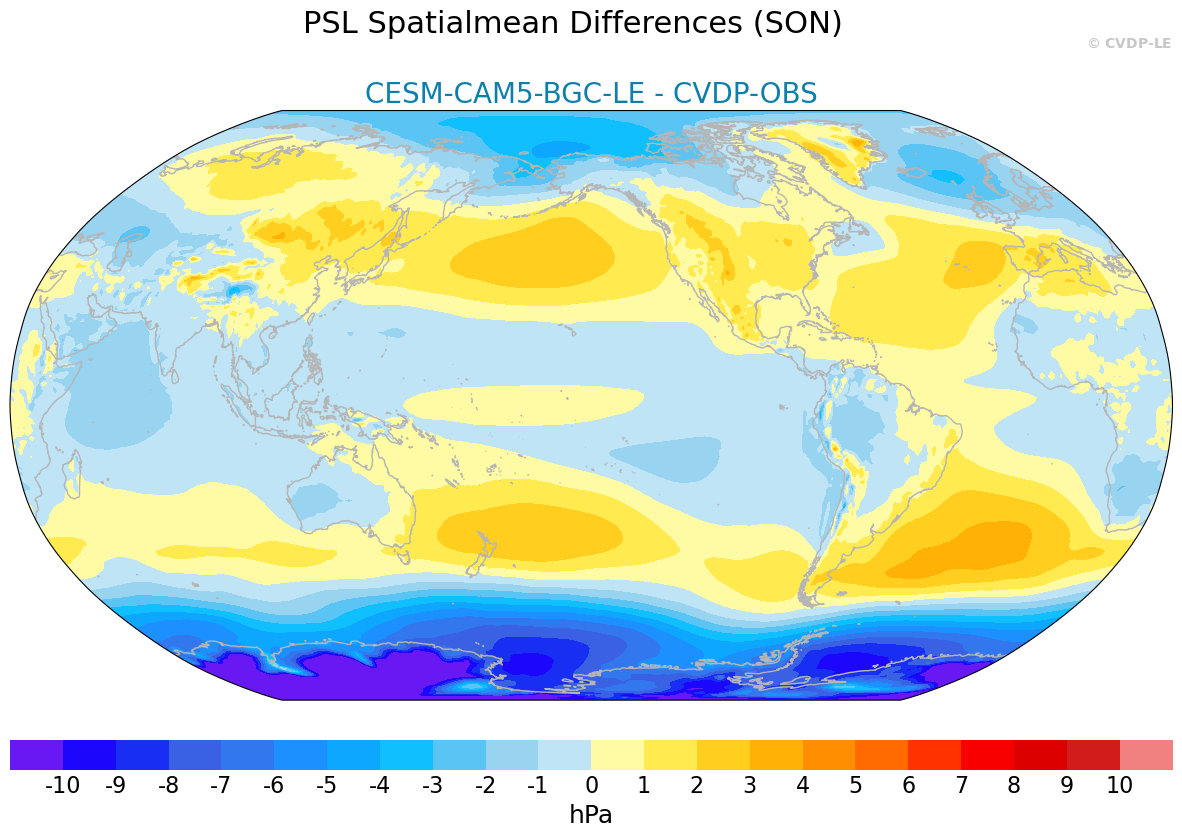

var None 

OR HERE?
1979-2013 

1920-2019 



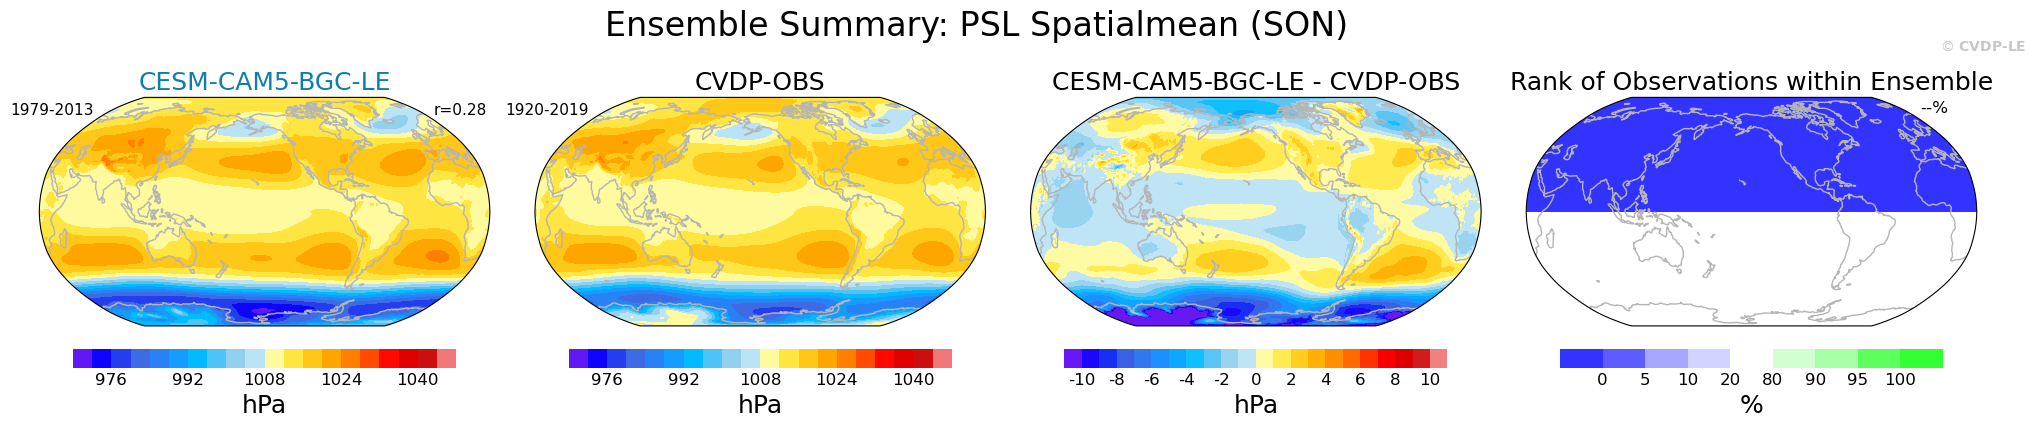

CPU times: user 1min 16s, sys: 582 ms, total: 1min 16s
Wall time: 1min 22s


In [19]:
%%time

#vn = "ts"
vns = ["ts", "psl"]
#vns = ["psl"]
#vns = ["ts"]
#ptypez = ["spatialmean"]
season = "SON"

#finarrs = [ts_cesm_avg,ts_obs_avg]
for i,vn in enumerate(vns):
    print("vn",vn,"\n---------------------\n")
    debug = True
    finarrs = finarrs_dict[vn] # = [ts_cesm_avg,ts_obs_avg]
    #if vn == "ts":
    #   debug = True
    for ptype in ptypes:
        print("ptype",ptype,"\n---------------------\n")

        #arr_var = ts_cesm_avg[f"{vn}_{ptype}_{season.lower()}"]
        #arr_var2 = ts_obs_avg[f"{vn}_{ptype}_{season.lower()}"]

        arr_var = finarrs[0][f"{vn}_{ptype}_{season.lower()}"]
        arr_var2 = finarrs[1][f"{vn}_{ptype}_{season.lower()}"]

        arrs_raw = [arr_var,arr_var2]

        arrs = []
        for i in arrs_raw:
            if vn == "ts":
                # interp to mask
                i = an.interp_mask(i, lsmask)
            if ptype == "trends":
                arr, res, fit = af.lin_regress(i)
            else:
                arr = i.mean(dim="time")
            arrs.append(arr)

        # Attempt to get difference data
        #-------------------------------
        arr_anom1 = arrs[0]
        arr_anom2 = arrs[1]

        # If the cases are different shapes, we need to interpolate one to the other first
        #NOTE: the value that comes out of interp_diff is either None, or interpolated difference array
        arr_prime = an.interp_diff(arr_anom1, arr_anom2)

        #print("arr_prime type:",type(arr_prime),"\n")
        # If arr_prime is None, then the two runs have already been interpolated (TS -> SST) or are the same grid/shape
        if arr_prime is None:
            arr_diff = arr_anom1 - arr_anom2
        else:
            arr_diff = (arr_prime - arr_anom2)

        # Plot details dict
        pdict = plot_dict[ptype]

        # Stacked lat/lon plot of the two runs
        indmem_plot(finarrs, arrs, vn, None, season, ptype, pdict, map_type="global", debug=debug)

        # Single plot of differences
        indmemdiff_plot(finarrs, arr_diff, vn, None, season, ptype, pdict, map_type="global", debug=debug)

        # Four panel plot of run, obs, differences, and rank
        ensemble_plot(finarrs, arrs, arr_diff, vn, None, season, ptype, pdict, map_type="global", debug=debug)


![](../cvdp/sst_trends_son.indmem.png)

![](../cvdp/sst_trends_son.summary.png)

![](../cvdp/sst_spatialmean_son.summary.png)

---

![DJF_PSL_climos copy.png](../cvdp/psl_trends_ann.summary.png)

---

The ensemble array lat/lon shape does not match the obs mask array.
Regridding to ensemble lats and lons
psl plotting things...
psl plotting things...


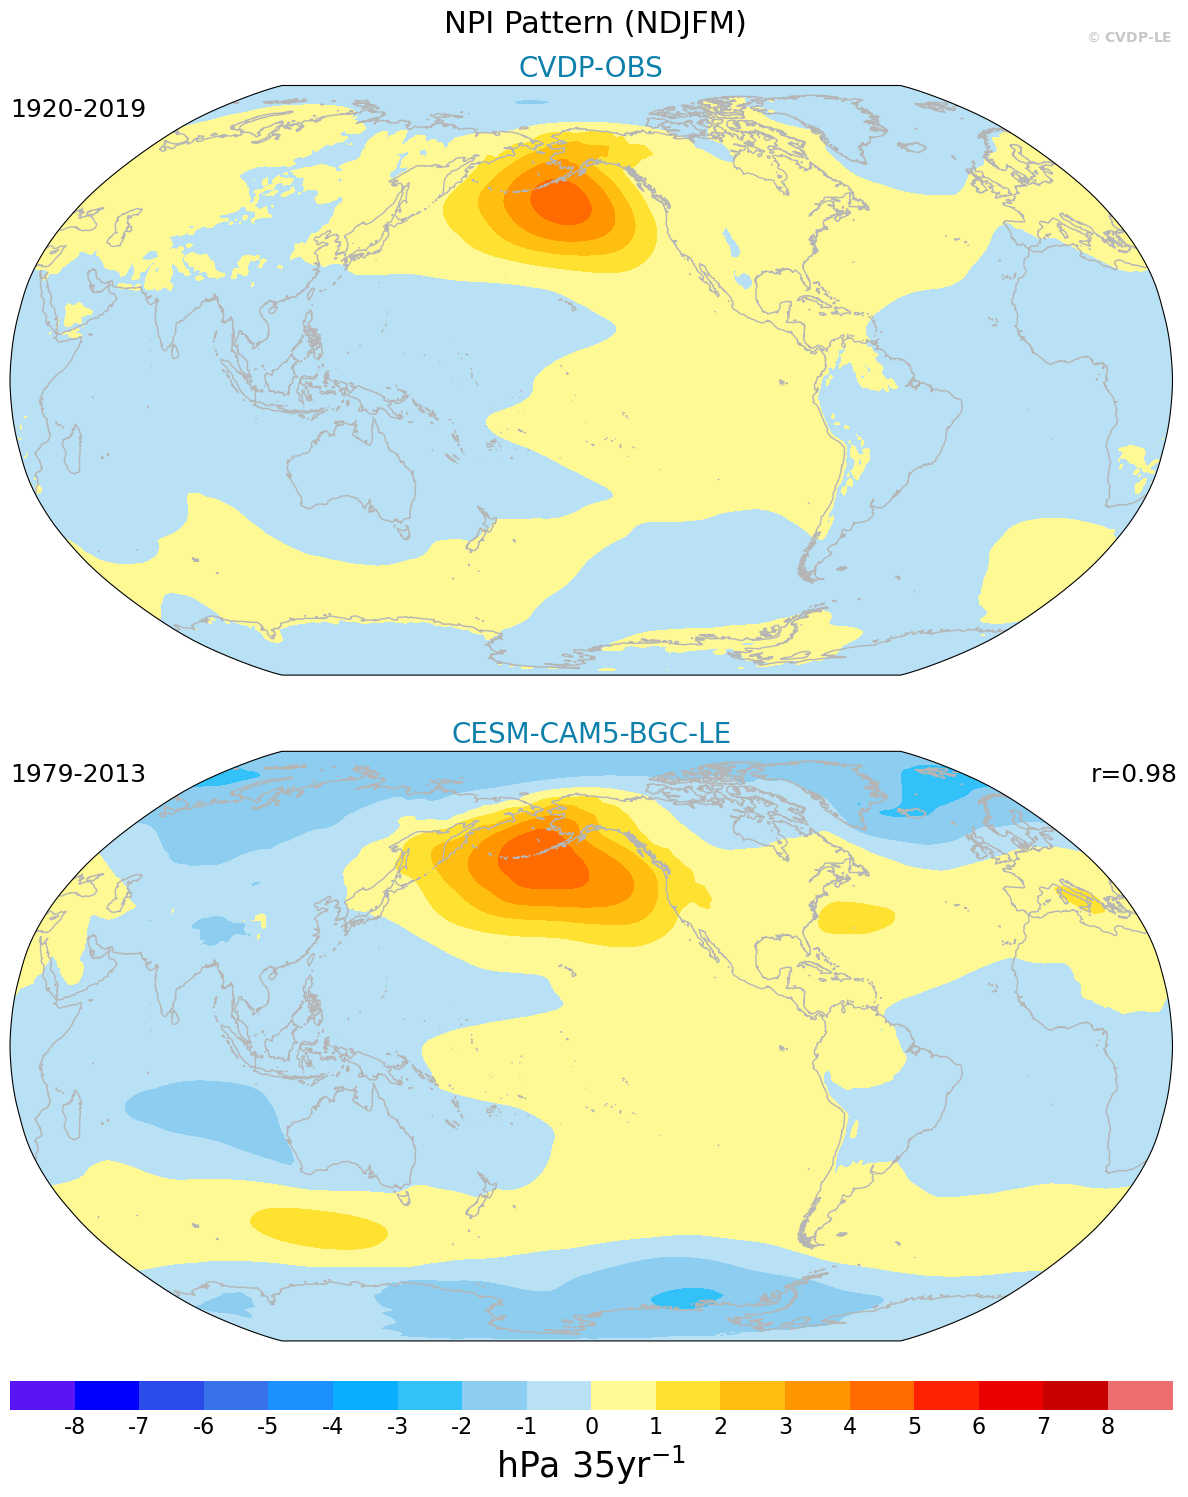


vn: psl 

NPI Pattern Differences (NDJFM)
 
 output/npi_pattern_ndjfm.indmemdiff.png
cbarticks diff plot trends [-8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8] 

tick_labels diff plot trends ['-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6', '7', '8'] 



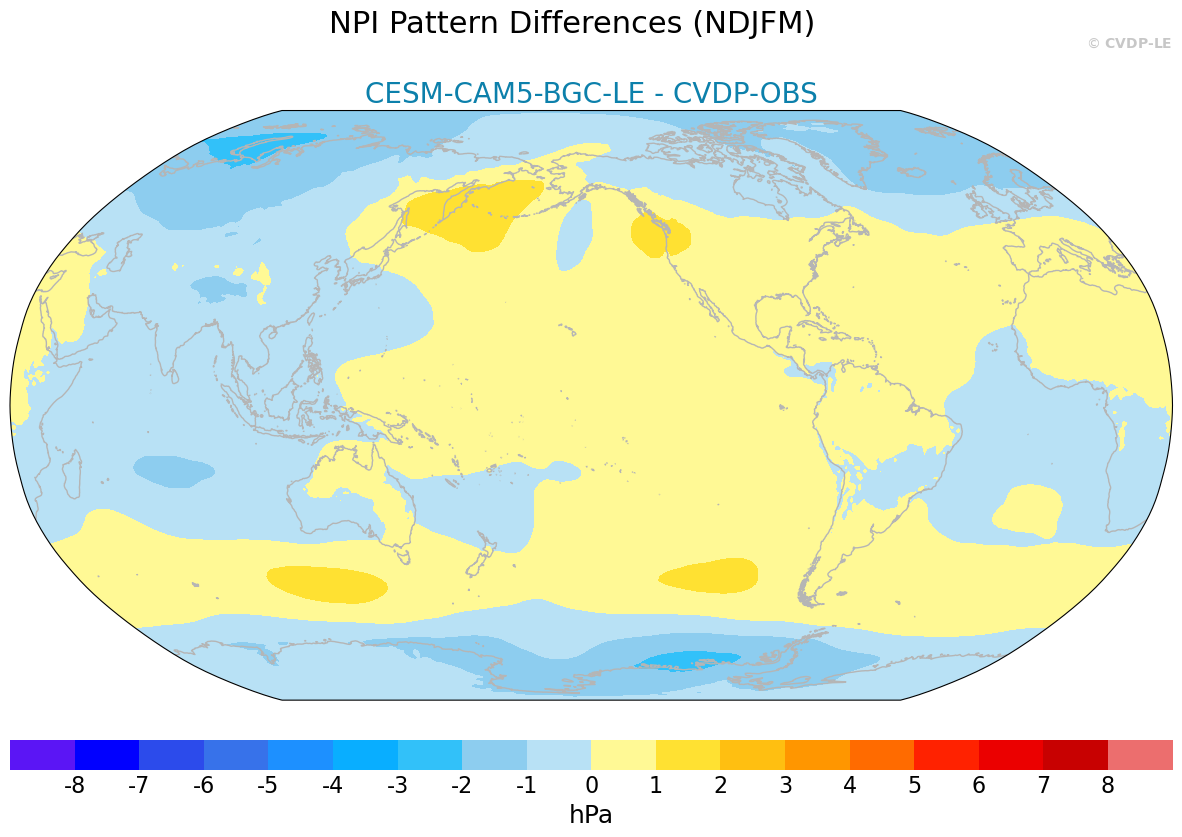

var None 

1979-2013 

1920-2019 



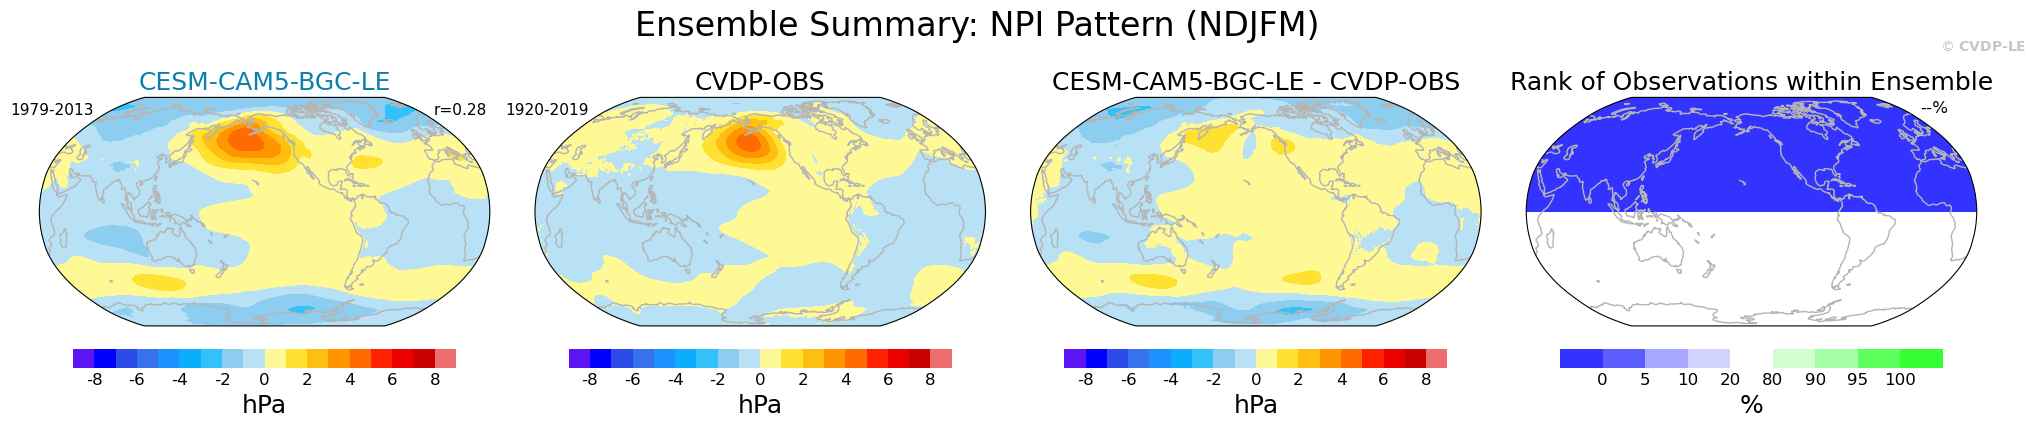

CPU times: user 7.13 s, sys: 36.2 ms, total: 7.16 s
Wall time: 8.81 s


In [20]:
%%time

vn = "psl"
ptype = "trends"
season = "NDJFM"
var = "NPI"

map_type="global"

finarrs = [psl_cesm_avg, psl_obs_avg]

arr_var = psl_cesm_avg[f"{vn}_{ptype}_{season.lower()}"]
arr_var2 = psl_obs_avg[f"{vn}_{ptype}_{season.lower()}"]

arrs_raw = [arr_var, arr_var2]


# NCL code:
# npi_ndjfm = wgt_areaave(arr_ndjfm(:,{30:65},{160:220}),coswgt({30.:65.}),1.0,0)

max_lat = 30
min_lat = 65
max_lon = 160
min_lon = 220

arrs = []
for arr_ndjfm in arrs_raw:
    npi_ndjfm = arr_ndjfm.sel(lat=slice(30,65), lon=slice(160,220))

    npi_ndjfm = npi_ndjfm.weighted(np.cos(np.radians(npi_ndjfm.lat))).mean(dim=('lat','lon'))

    npi_ndjfm_standarized = (npi_ndjfm - npi_ndjfm.mean(dim='time'))/npi_ndjfm.std(dim='time')
    npi = xs.linslope(npi_ndjfm_standarized, arr_ndjfm, dim='time')
    arrs.append(npi)

arr_anom1 = arrs[0]
arr_anom2 = arrs[1]
arr_prime = an.interp_diff(arr_anom1, arr_anom2)

if arr_prime is None:
    arr_prime = arr_anom1 - arr_anom2

arr_diff = (arr_prime - arrs[1])


pdict = plot_dict[ptype]


indmem_plot(finarrs, arrs, vn, None, season, ptype, pdict, map_type=map_type, debug=True)

# Single plot of differences
indmemdiff_plot(finarrs, arr_diff, vn, None, season, ptype, pdict, map_type=map_type, debug=True)

# Four panel plot of runs (2), differences, and rank
ensemble_plot(finarrs, arrs, arr_diff, vn, None, season, ptype, pdict, map_type=map_type, debug=True)

![](../cvdp/npi_pattern_ndjfm.summary.png)

---

# Polar Lat/Lon Plots

* EOF
* Others??

The ensemble array lat/lon shape does not match the obs mask array.
Regridding to ensemble lats and lons

vn: psl 

NAM Pattern Differences (SON)
 
 output/nam_pattern_son.indmemdiff.png
var NAM 

IS IT HERE?
1979-2013 

1920-2019 



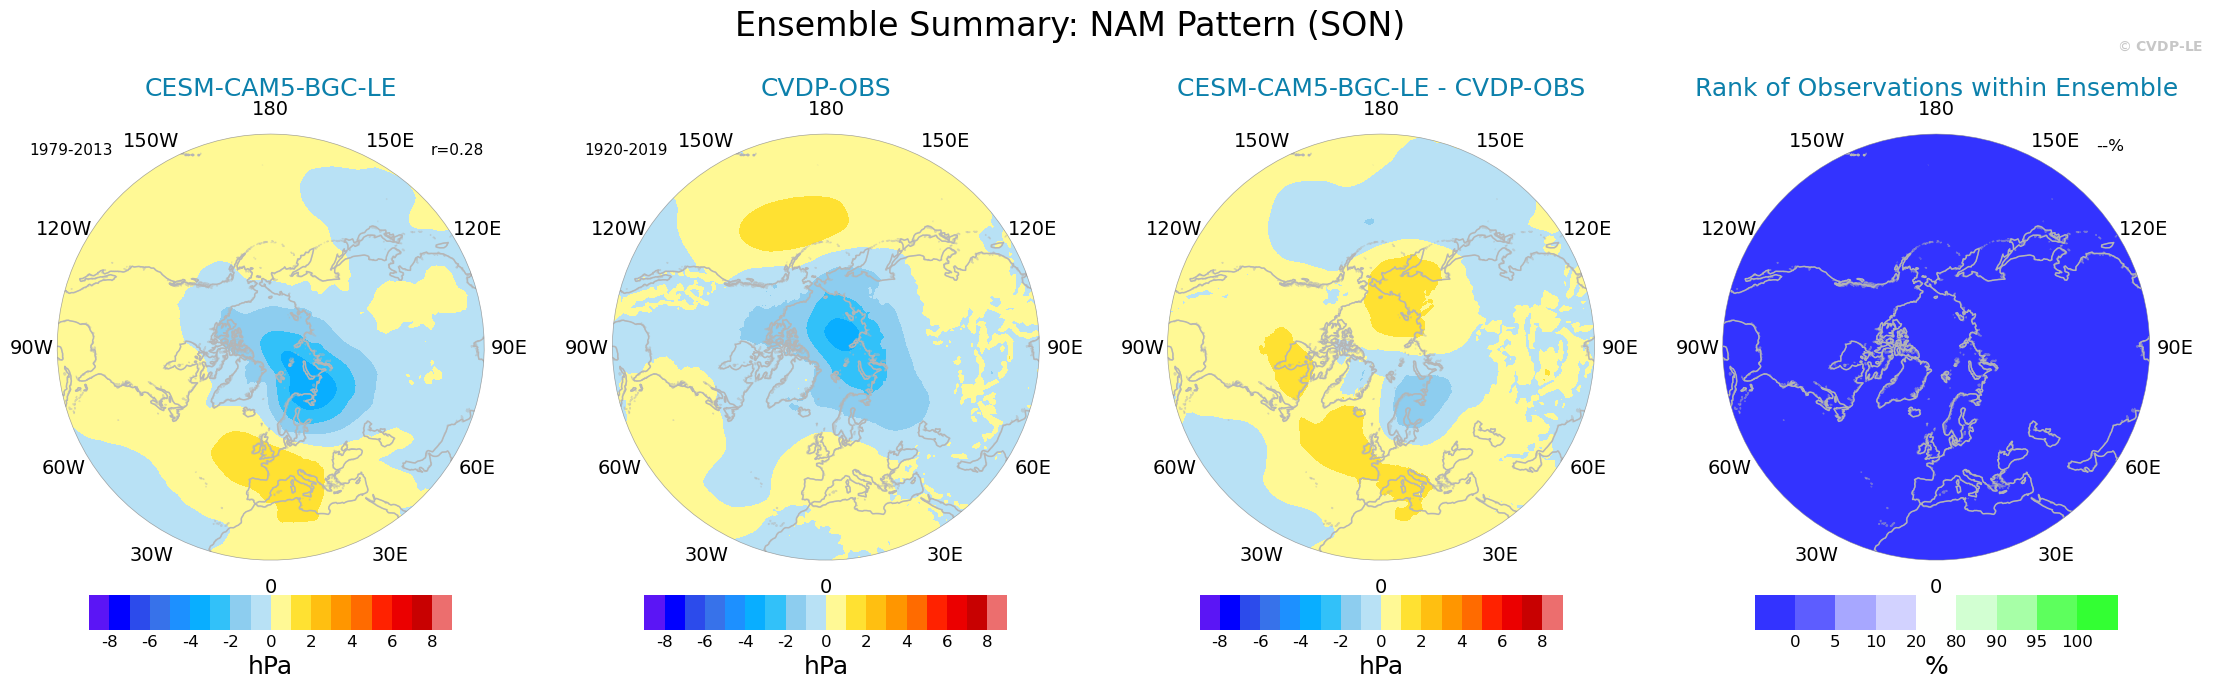

The ensemble array lat/lon shape does not match the obs mask array.
Regridding to ensemble lats and lons

vn: psl 

SAM Pattern Differences (SON)
 
 output/sam_pattern_son.indmemdiff.png
var SAM 

IS IT HERE?
1979-2013 

1920-2019 



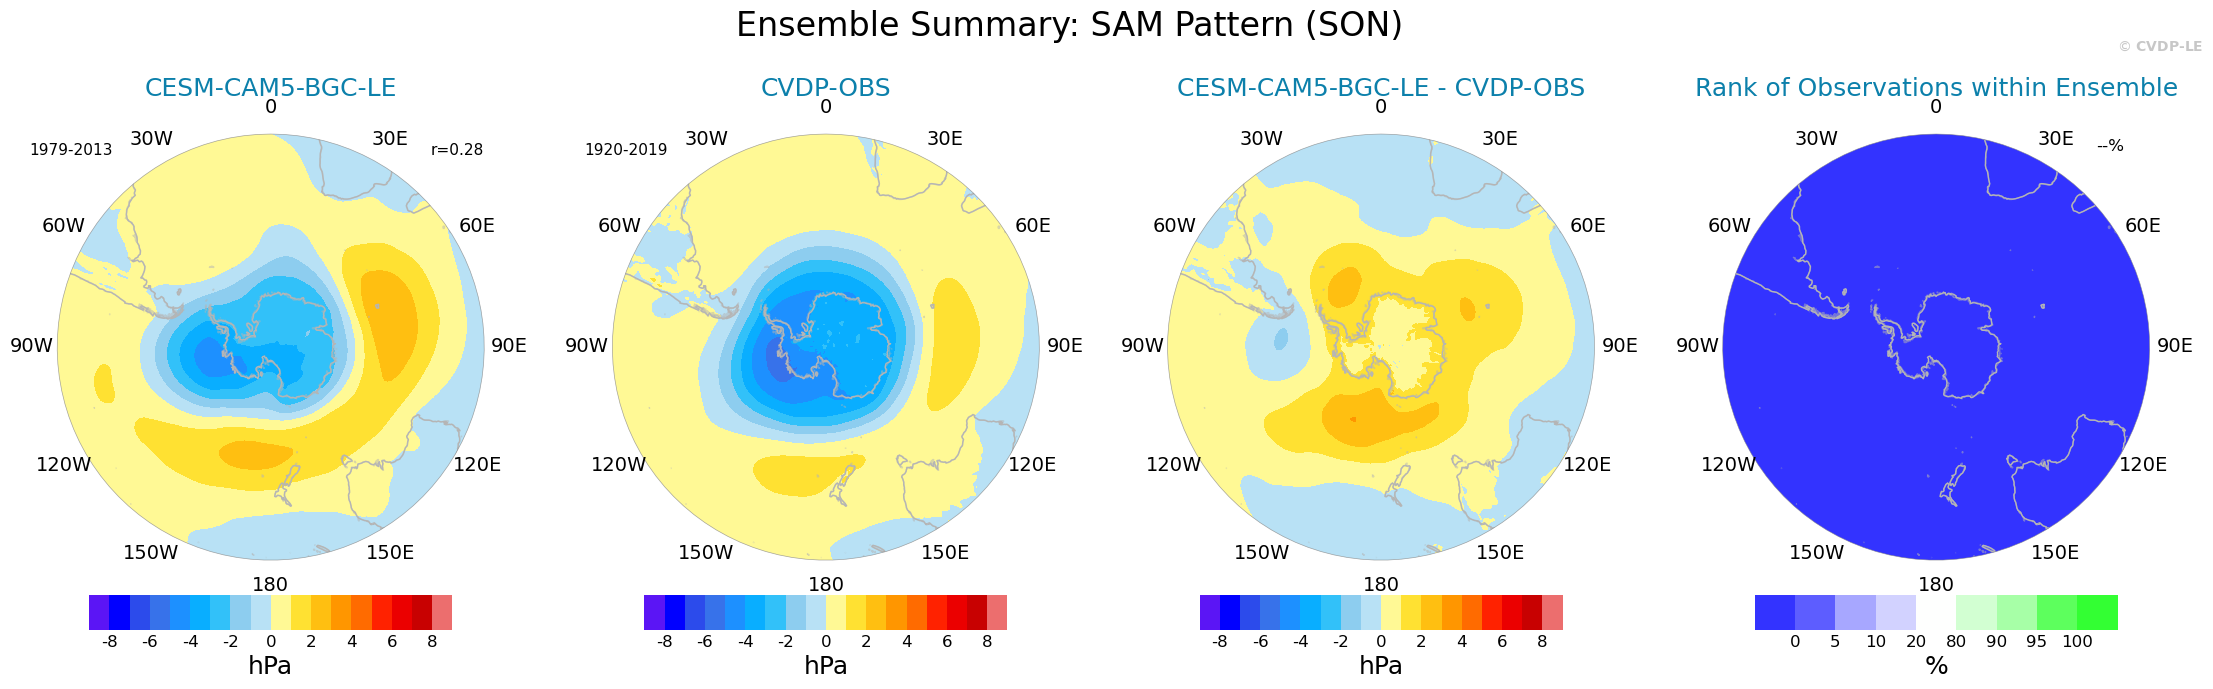

The ensemble array lat/lon shape does not match the obs mask array.
Regridding to ensemble lats and lons

vn: psl 

PSA1 Pattern Differences (SON)
 
 output/psa1_pattern_son.indmemdiff.png
var PSA1 

IS IT HERE?
1979-2013 

1920-2019 



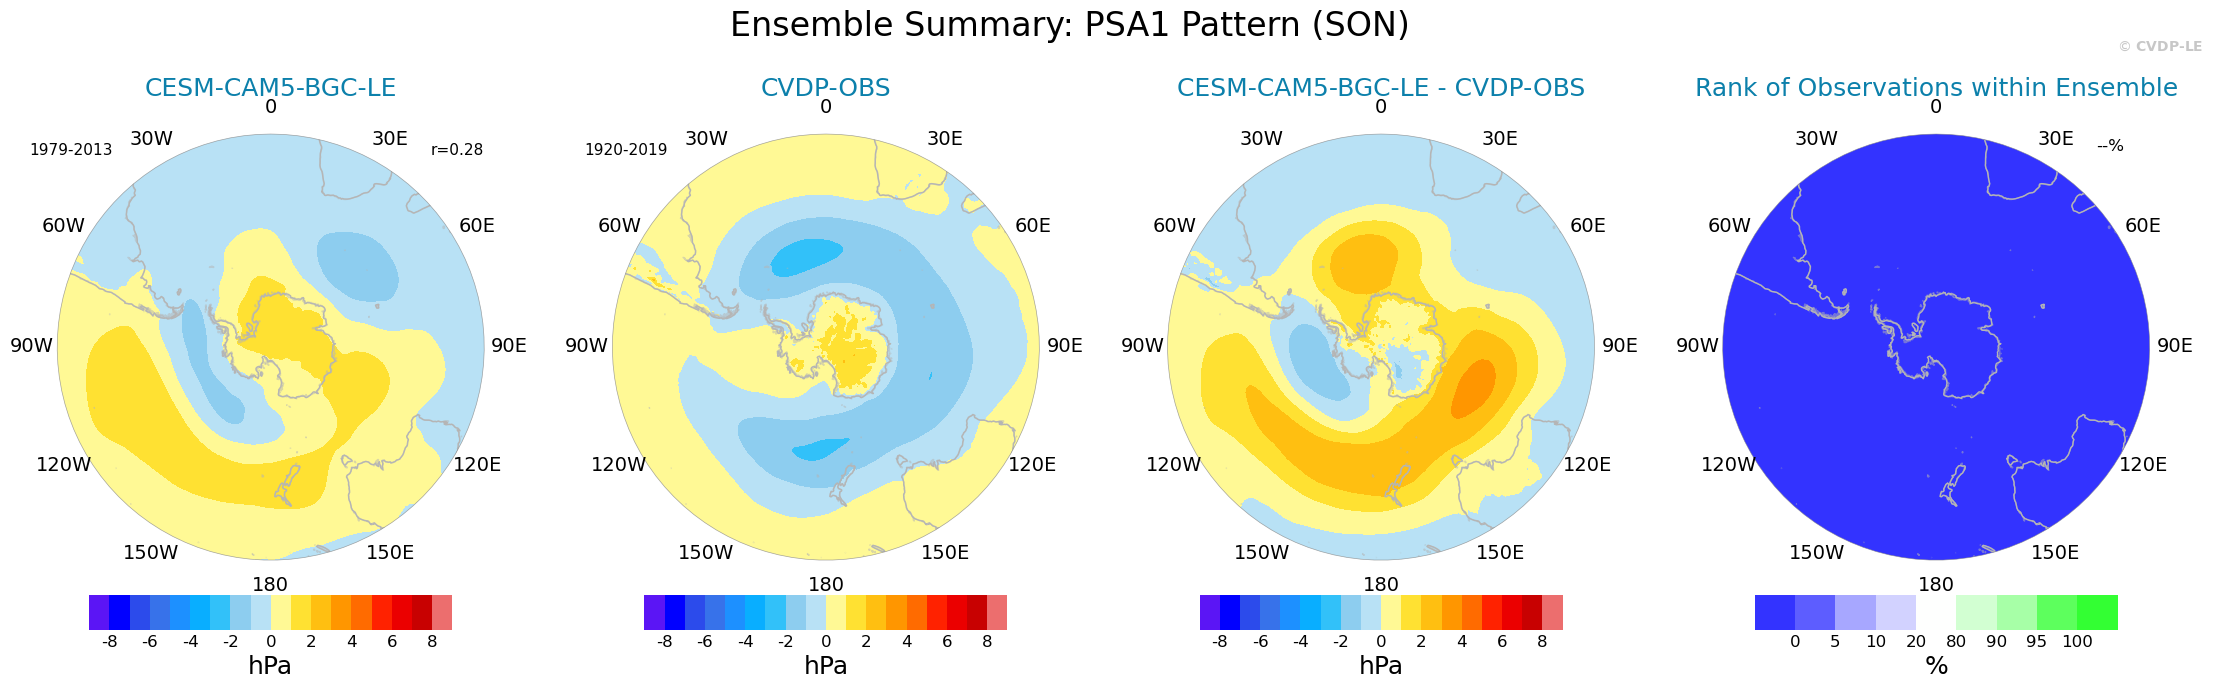

The ensemble array lat/lon shape does not match the obs mask array.
Regridding to ensemble lats and lons

vn: psl 

PSA2 Pattern Differences (SON)
 
 output/psa2_pattern_son.indmemdiff.png
var PSA2 

IS IT HERE?
1979-2013 

1920-2019 



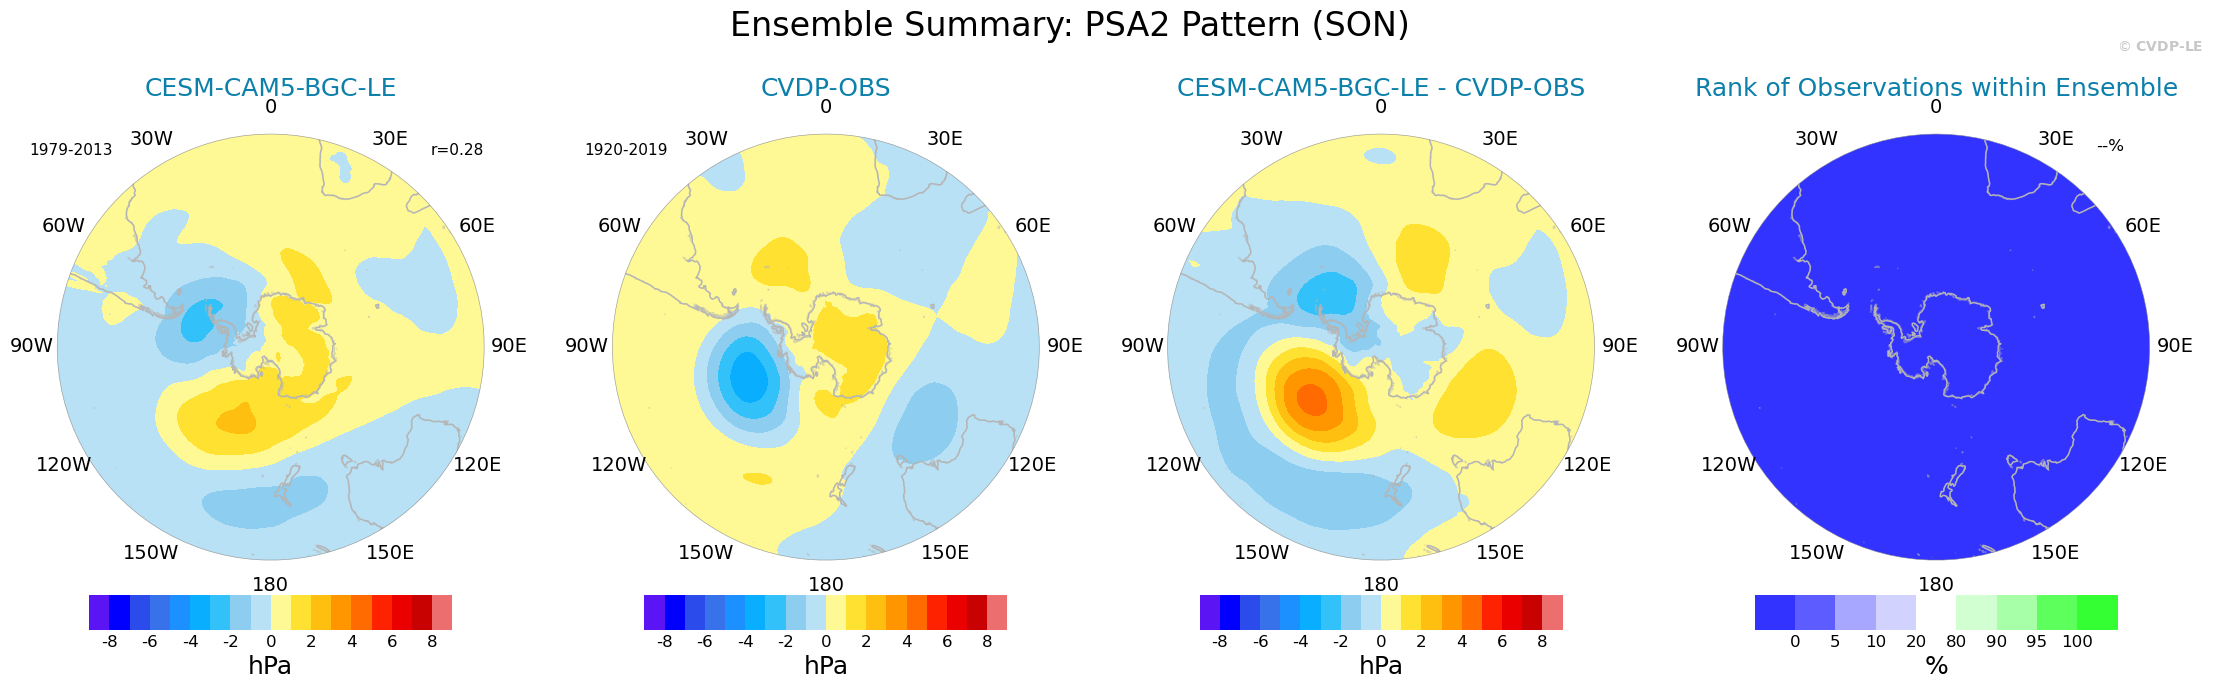

CPU times: user 45 s, sys: 1.52 s, total: 46.5 s
Wall time: 52.1 s


In [21]:
%%time

latlon_dict = {}
latlon_dict['e'] = 0
latlon_dict['w'] = 360

vn = "psl"
season = "SON"
map_type = "polar"

nh_vars = ["NAM"]
sh_vars = ["SAM", "PSA1", "PSA2"]
eof_vars = nh_vars+sh_vars


ptype = "trends"

pdict = plot_dict[ptype]

arr_cesm = psl_cesm_trends[vn]
arr_obs = psl_obs_trends[vn]
finarrs = [arr_cesm,arr_obs]

#arrs_raw = [arr_cesm,arr_obs]

arrs = []

# Set number of EOF functions(?)
eof_nums = 3


for var in eof_vars:
    if var in nh_vars:
        latlon_dict['n'] = 90
        latlon_dict['s'] = 20

    if var in sh_vars:
        latlon_dict['n'] = -20
        latlon_dict['s'] = -90

    # Get EOF
    arrs = []
    ahh = []
    for i,arr in enumerate(finarrs):

        # Set EOF number for variable
        if var == "NAM" or var == "SAM":
            num = 0
        if var == "PSA1":
            num = 1
        if var == "PSA2":
            num = 2

        eofs, pcs, SLP = an.get_eof(arr, season, latlon_dict, eof_nums)
        pcs_num = pcs.sel(pc=num)
        pcs_norm_num = (pcs_num - pcs_num.mean(dim='time'))/pcs_num.std(dim='time')
        if ((var == "SAM") and (i == 0)) or ((var == "PSA2") and (i != 0)):
            pcs_norm_num = pcs_norm_num * -1

        #if num != 0:
        #    if i == 0:
        #        pcs_norm_num = pcs_norm_num * -1

        pattern = xs.linslope(pcs_norm_num, SLP, dim='time')


        #if (num != 0) or (var == "SAM"):
        #    pattern = pattern * -1
            #pcs_norm_num = pcs_norm_num *  -1

        ahh.append(pcs_norm_num)

        arrs.append(pattern)

    arr1 = arrs[0]
    arr2 = arrs[1]

    # Check to see if these are on the same grid
    # NOTE: This will be true for SST's as they already have been regridded
    # due to masking values.
    arr_prime = an.interp_diff(arr1, arr2)

    if arr_prime is None:
        arr_prime = arr1 - arr2

    arr_diff = (arr_prime - arr2)

    #Plotting
    #--------
    # Stacked plot of individual members
    indmem_plot([psl_cesm_trends,psl_obs_trends], arrs, vn, var, season, ptype, pdict, map_type=map_type, debug=False)

    # Single plot of differences
    indmemdiff_plot([psl_cesm_trends,psl_obs_trends], arr_diff, vn, var, season, ptype, pdict, map_type=map_type, debug=False)

    ensemble_plot(finarrs, arrs, arr_diff, vn, var, season, ptype, pdict, map_type=map_type, debug=True)

    # Plot time series
    pf.timeseries_plot(var, season, ahh[0], ahh[1], debug=False)

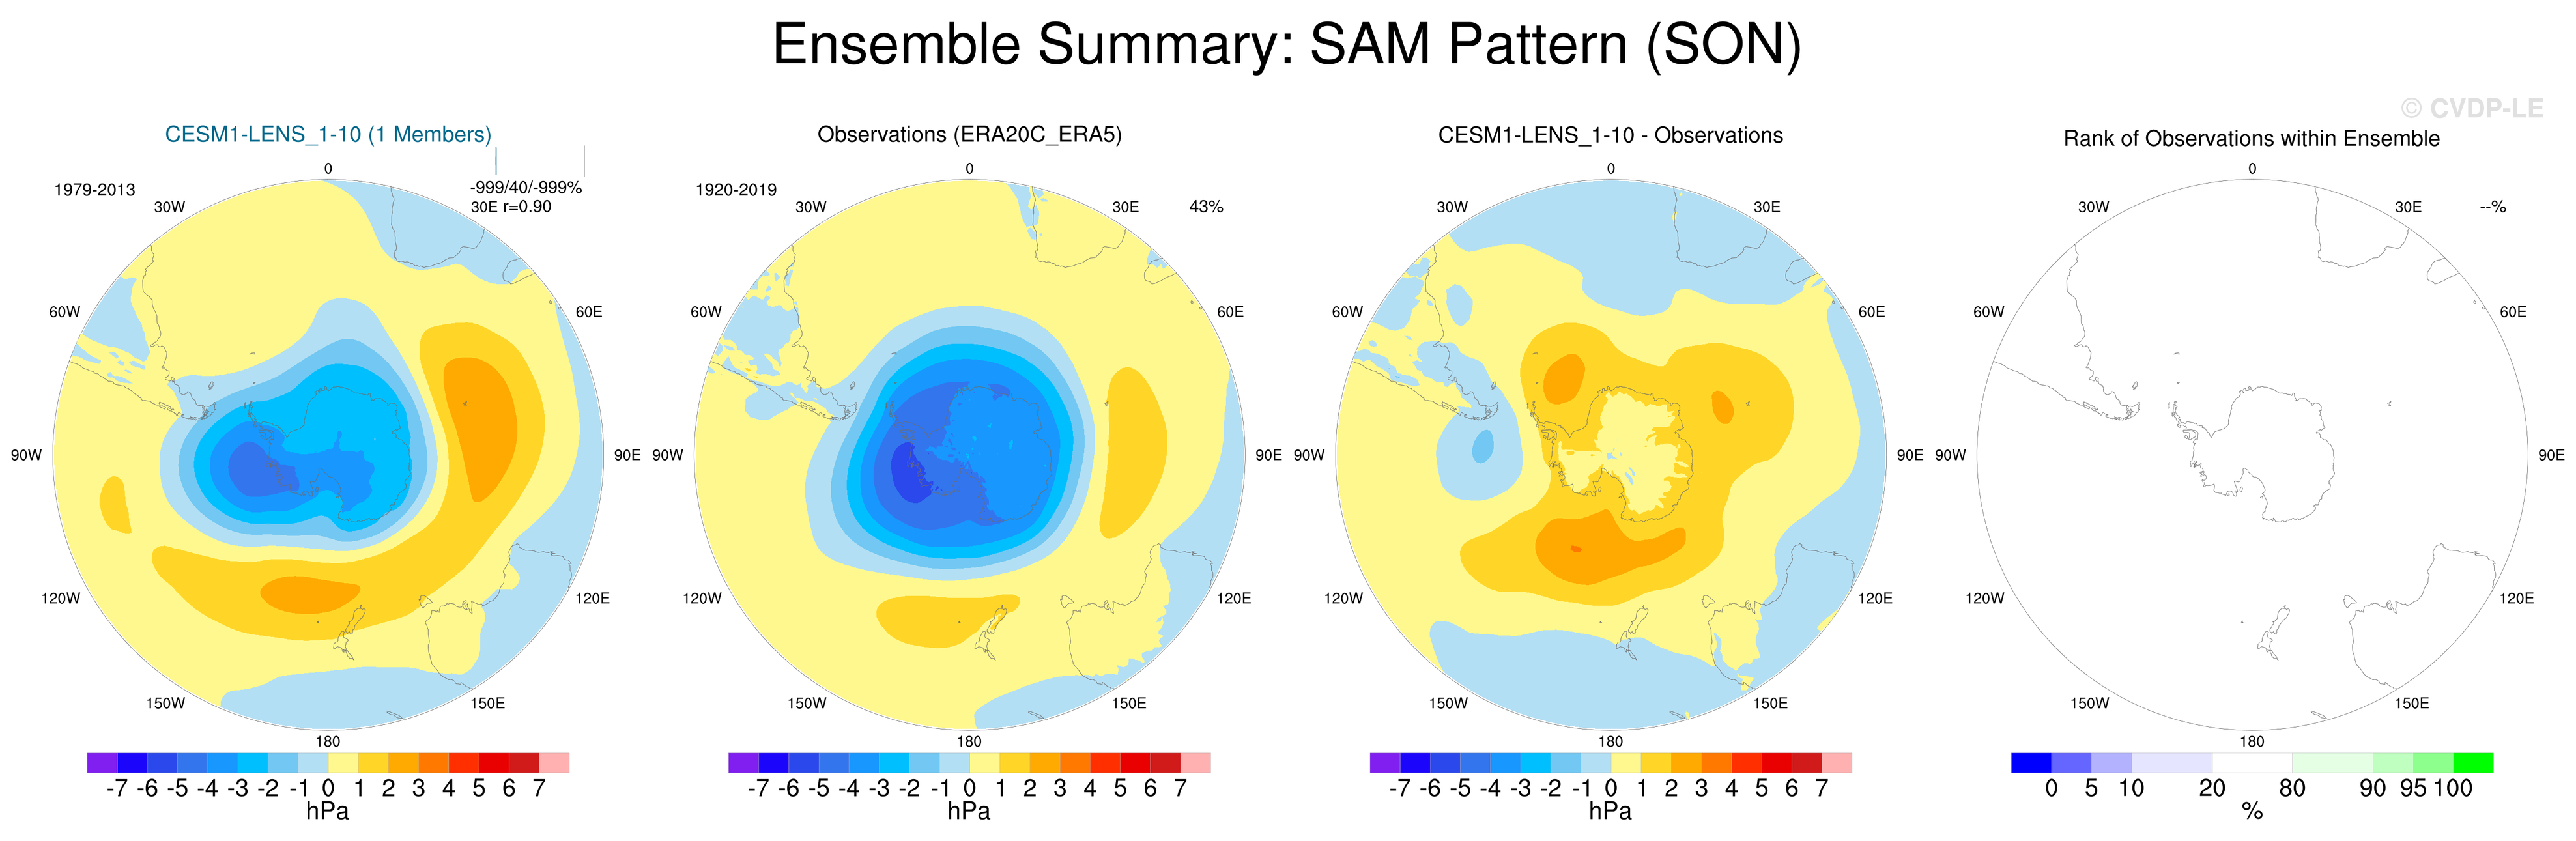

In [22]:
import IPython.display as display
from PIL import Image
ext = "summary"
season = "son"
ptype = "pattern"
var = "sam"
image_path = f'../cvdp/{var}_{ptype}_{season}.{ext}.png'
display.display(Image.open(image_path))